In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
h5py._errors.unsilence_errors()
from mpl_toolkits.axes_grid1 import make_axes_locatable


# SUGGESTION: create all folders for storing results
if not os.path.exists('./vis'):
    os.mkdir('./vis')

if not os.path.exists('./vis_results'):
    os.mkdir('./vis_results')

if not os.path.exists('./model256_weights'):
    os.mkdir('./model256_weights')


In [2]:
def log_transform(im):
    '''returns log(image) scaled to the interval [0,1]'''
    try:
        (min, max) = 1e-16, 1 #(im[im > 0].min(), im.max())
        # print(im.min(), im.max())
        if (max > min) and (max > 0):
            return (np.log(im.clip(min, max)) - np.log(min)) / (np.log(max) - np.log(min))
    except:
        pass
    return im

def matshow(np_data, figsize = (12, 12), title=None, vmin=None, vmax=None):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    if vmin is None and vmax is None:
        im = ax.matshow(np_data)
    else:
        im = ax.matshow(np_data, vmin=vmin, vmax=vmax)
    
    ax.set_title(f'{title}')
      
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
    plt.show()


def matshow2(C, eps, figsize = (12, 12), title=None, save_filename=None):
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    im = ax[0].matshow(C, vmin = 0, vmax = 1)
    ax[0].set_title(f'C at {title}')
    im.set_clim(0, 1)
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    im = ax[1].matshow(eps)
    ax[1].set_title(f'eps at {title}')
    im.set_clim(0, 1)

    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    plt.tight_layout()
    
    if save_filename:
        plt.savefig(f'vis/{save_filename}.pdf', dpi=800)
    plt.show()


def matshow3(C, eps, dissolution, figsize = (12, 12), title=None, save_filename=None):
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    im = ax[0].matshow(C, vmin = 0, vmax = 1)
    ax[0].set_title(f'C at {title}')
    im.set_clim(0, 1)
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    im = ax[1].matshow(eps)
    ax[1].set_title(f'eps at {title}')
    im.set_clim(0, 1)

    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    im = ax[2].matshow(dissolution)
    ax[2].set_title(f'dissolution (log(difference)) at {title}')
    im.set_clim(0, 1)

    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    plt.tight_layout()
    
    if save_filename:
        plt.savefig(f'vis/{save_filename}.pdf', dpi=800)
    plt.show()


def matshow4(C, eps, Ux, Uy, figsize = (12, 12), title=None):
    fig, ax = plt.subplots(2, 2, figsize=figsize)
    im = ax[0, 0].matshow(C, vmin = 0, vmax = 1)
    ax[0, 0].set_title(f'{title} for C')
      
    divider = make_axes_locatable(ax[0, 0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    im = ax[0, 1].matshow(eps)
    ax[0, 1].set_title(f'{title} for eps')
      
    divider = make_axes_locatable(ax[0, 1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    im = ax[1, 0].matshow(Ux)
    ax[1, 0].set_title(f'{title} for Ux')
      
    divider = make_axes_locatable(ax[1, 0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    im = ax[1, 1].matshow(Uy)
    ax[1, 1].set_title(f'{title} for Uy')
      
    divider = make_axes_locatable(ax[1, 1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

In [3]:
def read_simulation_hdf(file_name):
    print(f'loading the file: {file_name}')
    data_dict = {}

    with h5py.File(file_name, "r") as file_handle:
        # List all groups
        print(f"Keys: {file_handle.keys()}")
        scaling_factor = 1
        for key_ in file_handle.keys():
            if 'key_' == 'C':
                scaling_factor = 1 # 100
            elif 'key_' == 'Ux' or 'key_' == 'Uy':
                scaling_factor = 1 # 1000
            
            data_dict[key_] = scaling_factor * np.array(file_handle[key_])
            print(f'Done loading the variable {key_} of shape: {data_dict[key_].shape}')

        print(f'Done with {file_name} == closing file now')

    return data_dict['C'], data_dict['eps'], data_dict['Ux'], data_dict['Uy'],


def load_datafiles(data_filenames):
    # snapshot_indices will split the data in time into train and validation
    data_dict = {
        'C': [], # list of np arrays
        'eps': [],
        'Ux': [],
        'Uy': [],
    }

    for filename in data_filenames:
        C, eps, Ux, Uy = read_simulation_hdf(filename)
        data_dict['C'].append(C[2:-2, 2:-2, :])
        data_dict['eps'].append(eps[2:-2, 2:-2, :])
        data_dict['Ux'].append(Ux[2:-2, 2:-2, :])
        data_dict['Uy'].append(Uy[2:-2, 2:-2, :])
    return data_dict

def get_filelist():
    from itertools import permutations, product
    # permutations = list(permutations(range(4), 2))
    permutations = list(product(range(4), repeat=2))

    file_list = []
    properties_list = []
    for idx1, idx2 in permutations:
        # filename_hdf = f'Pe{peclet_value}_K{k_value}_101steps.hdf5'
        # filename_hdf = f'data_new/Pe{peclet_value[data_idx]}_K{k_value[data_idx]}.hdf5'
        file_name = f'256modelruns/Pe1_K1_{idx1}_{idx2}.hdf5'
        file_list.append(file_name)
    return file_list

In [4]:
file_list = get_filelist()
print(file_list)

data_list = load_datafiles(file_list)

['256modelruns/Pe1_K1_0_0.hdf5', '256modelruns/Pe1_K1_0_1.hdf5', '256modelruns/Pe1_K1_0_2.hdf5', '256modelruns/Pe1_K1_0_3.hdf5', '256modelruns/Pe1_K1_1_0.hdf5', '256modelruns/Pe1_K1_1_1.hdf5', '256modelruns/Pe1_K1_1_2.hdf5', '256modelruns/Pe1_K1_1_3.hdf5', '256modelruns/Pe1_K1_2_0.hdf5', '256modelruns/Pe1_K1_2_1.hdf5', '256modelruns/Pe1_K1_2_2.hdf5', '256modelruns/Pe1_K1_2_3.hdf5', '256modelruns/Pe1_K1_3_0.hdf5', '256modelruns/Pe1_K1_3_1.hdf5', '256modelruns/Pe1_K1_3_2.hdf5', '256modelruns/Pe1_K1_3_3.hdf5']
loading the file: 256modelruns/Pe1_K1_0_0.hdf5
Keys: <KeysViewHDF5 ['C', 'Ux', 'Uy', 'eps', 'time']>
Done loading the variable C of shape: (260, 260, 101)
Done loading the variable Ux of shape: (260, 260, 101)
Done loading the variable Uy of shape: (260, 260, 101)
Done loading the variable eps of shape: (260, 260, 101)
Done loading the variable time of shape: (101,)
Done with 256modelruns/Pe1_K1_0_0.hdf5 == closing file now
loading the file: 256modelruns/Pe1_K1_0_1.hdf5
Keys: <KeysV

In [5]:
# estimate sample mean and std -- this should be done better

n_training_samples = 12


C = np.stack([data_list['C'][idx] for idx in range(n_training_samples)])
eps = np.stack([data_list['eps'][idx] for idx in range(n_training_samples)])
Ux = np.stack([data_list['Ux'][idx] for idx in range(n_training_samples)])
Uy = np.stack([data_list['Uy'][idx] for idx in range(n_training_samples)])

Ux_mean, Ux_std = Ux.mean(), Ux.std()
Uy_mean, Uy_std = Uy.mean(), Uy.std()
eps_mean, eps_std = eps.mean(), eps.std()


print(Ux_mean, Ux_std)
print(Uy_mean, Uy_std)
print(eps_mean, eps_std)

3.726297038766906e-06 9.616023499470504e-06
-1.3384671559548906e-07 6.650924948207739e-06
0.5050692824885601 0.48431949117856576


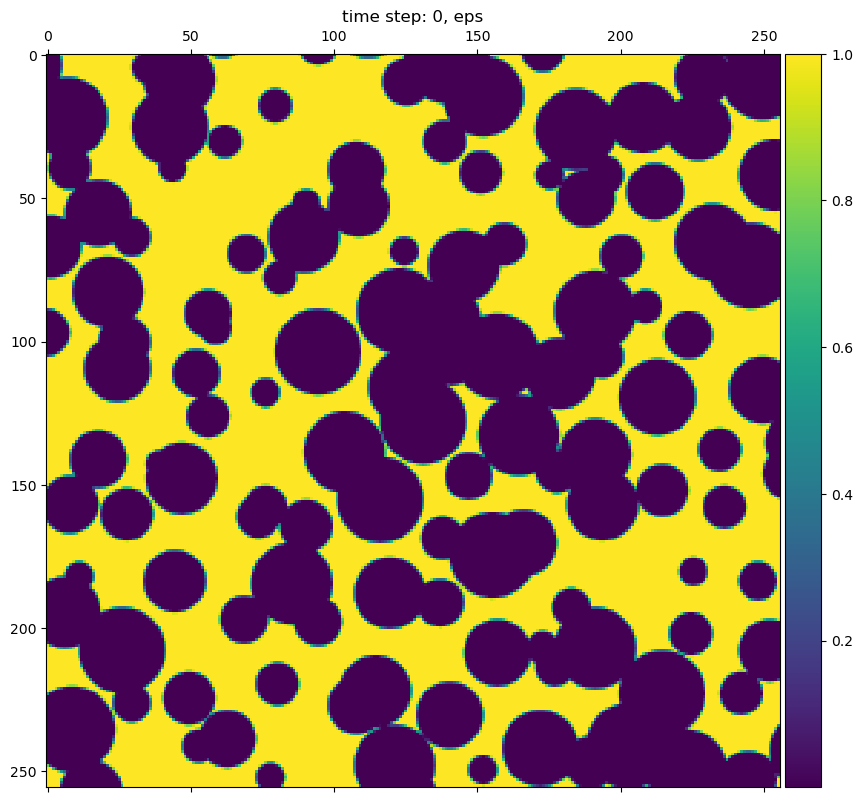

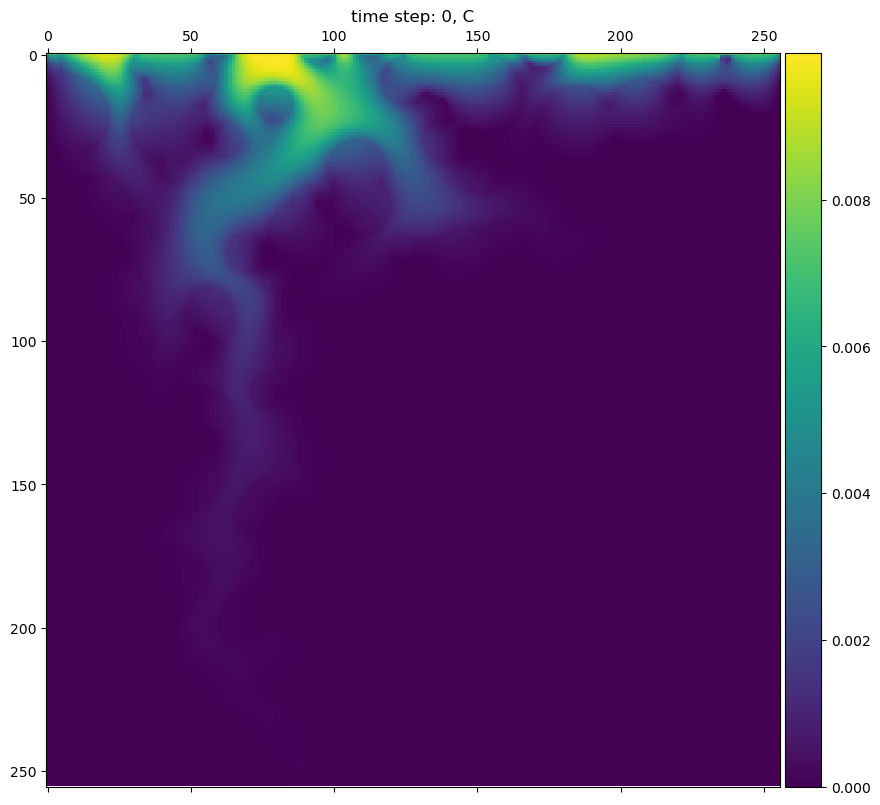

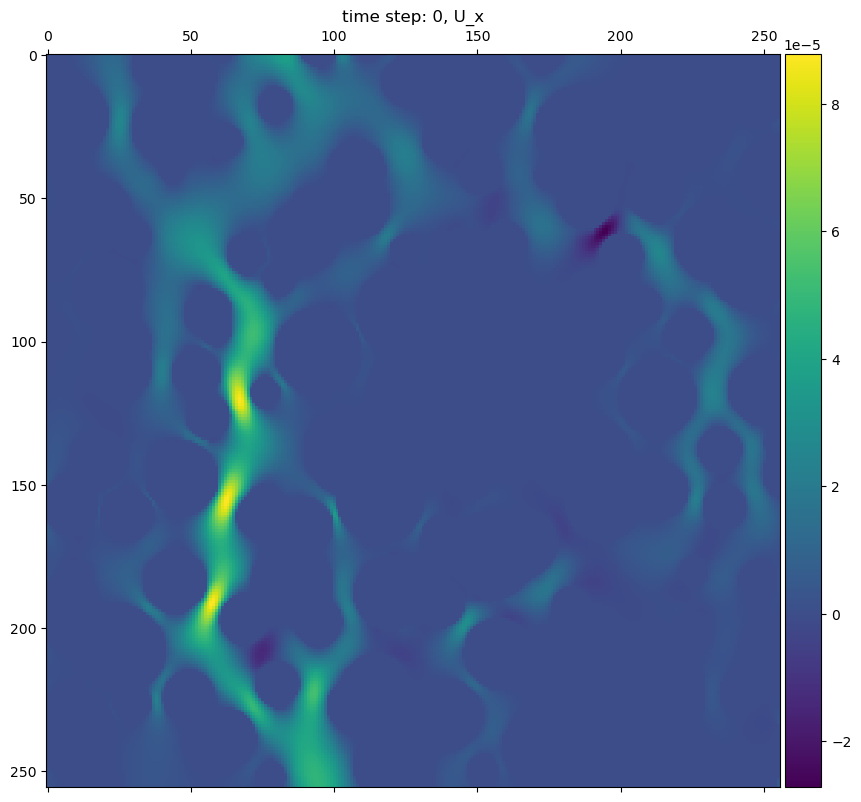

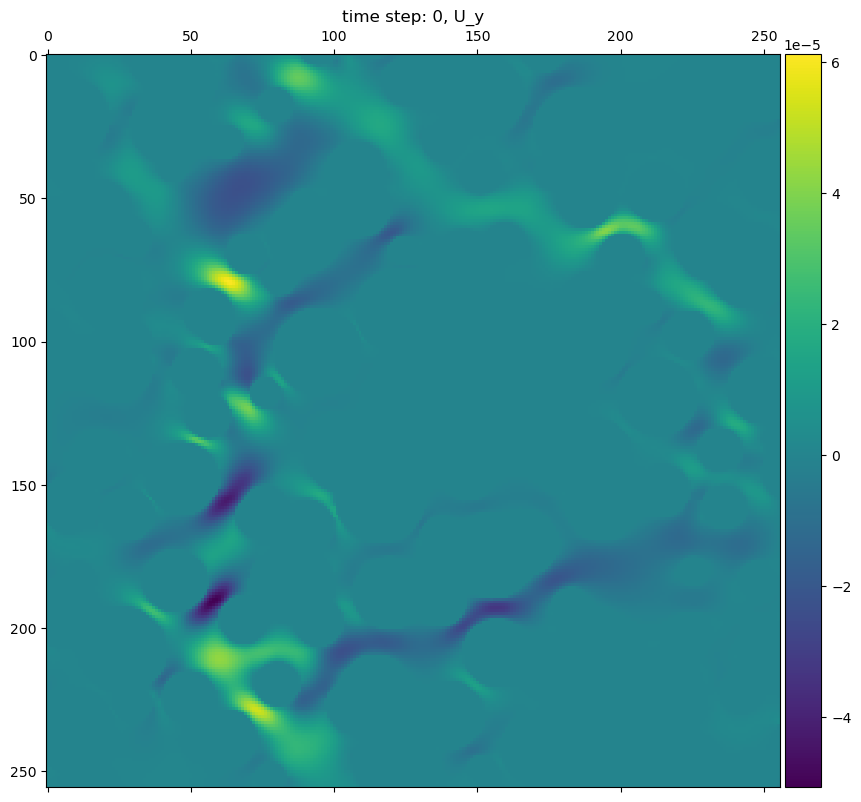

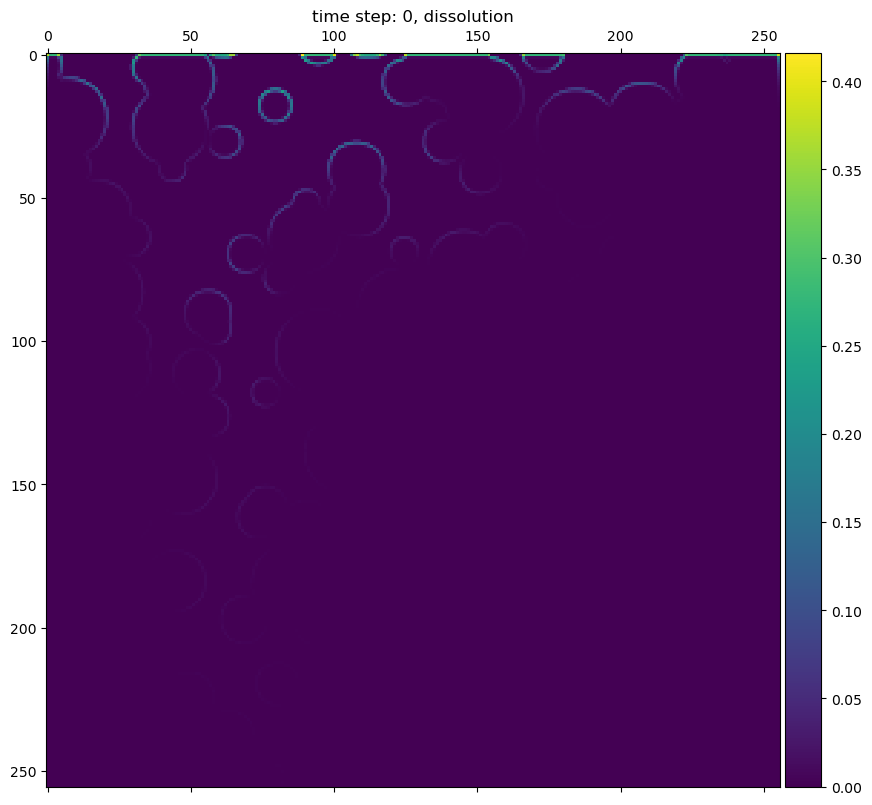

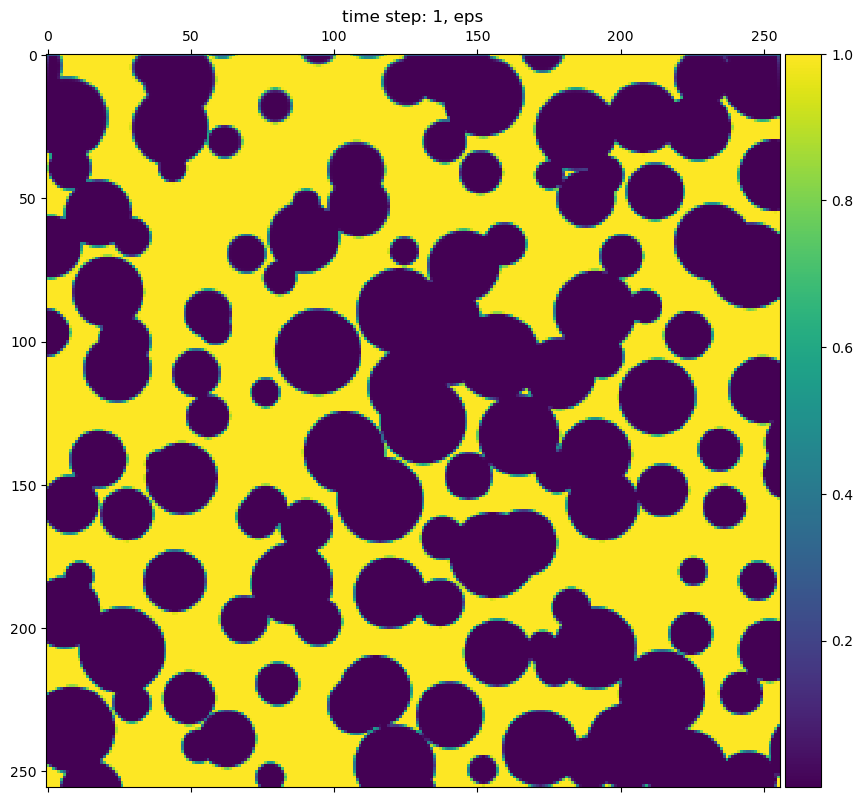

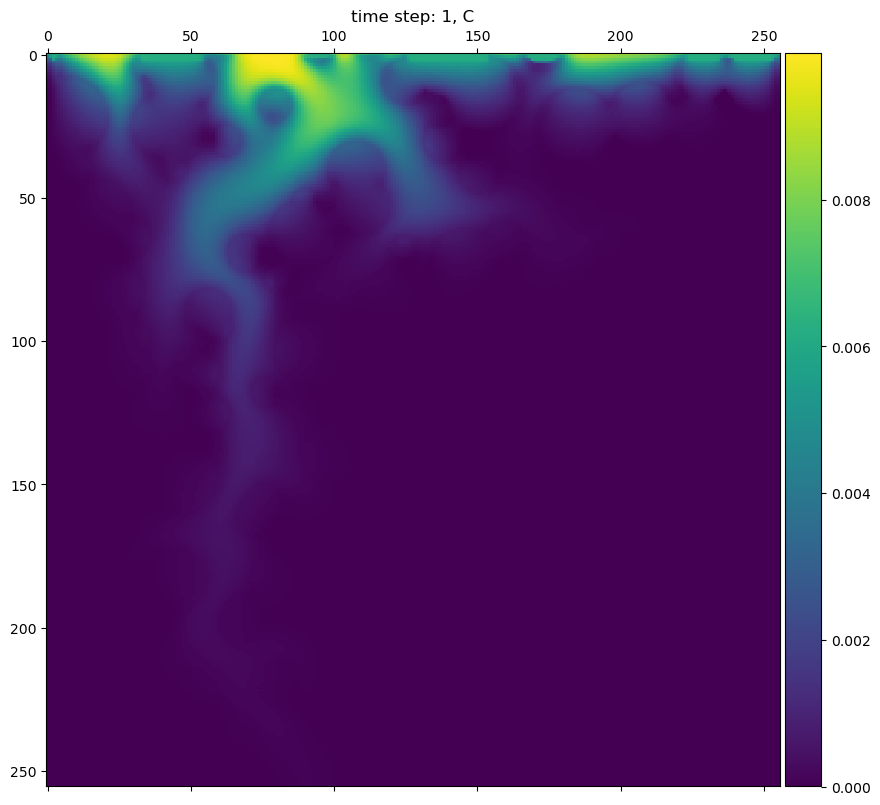

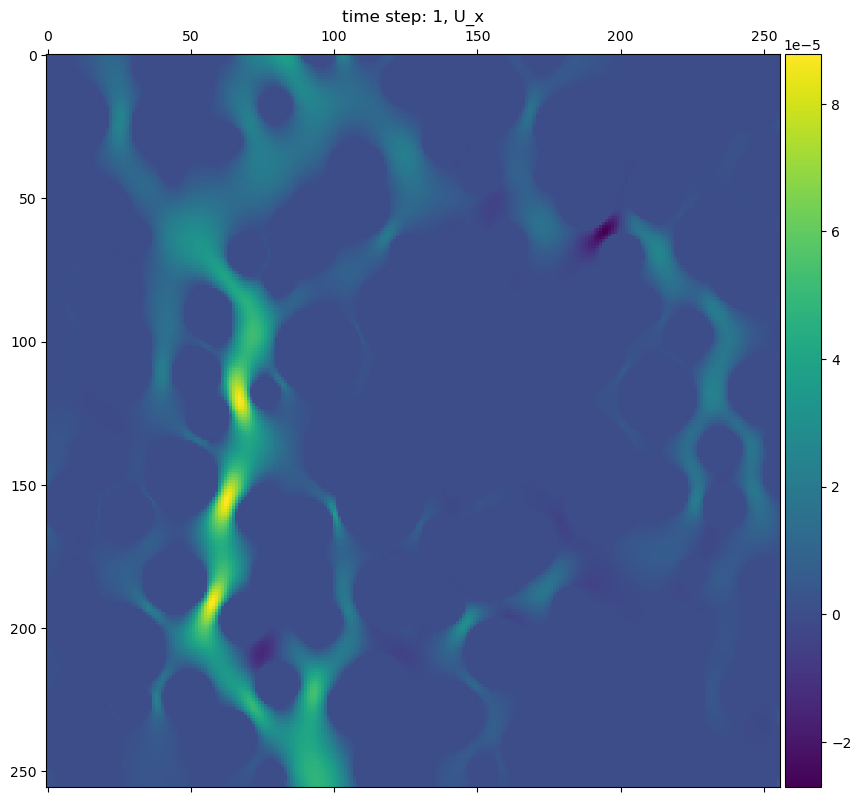

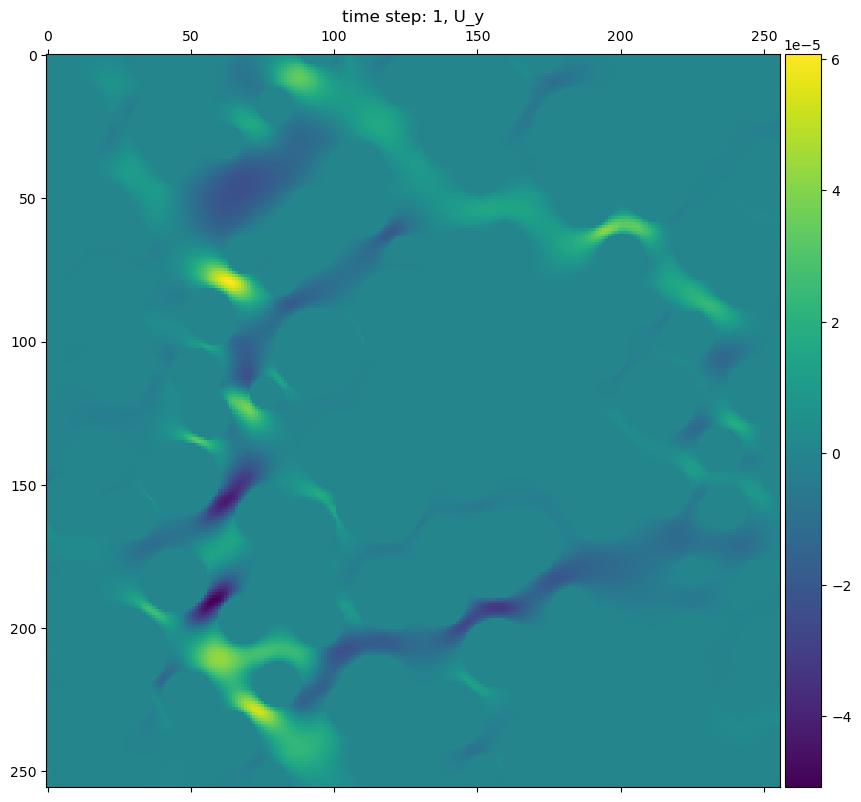

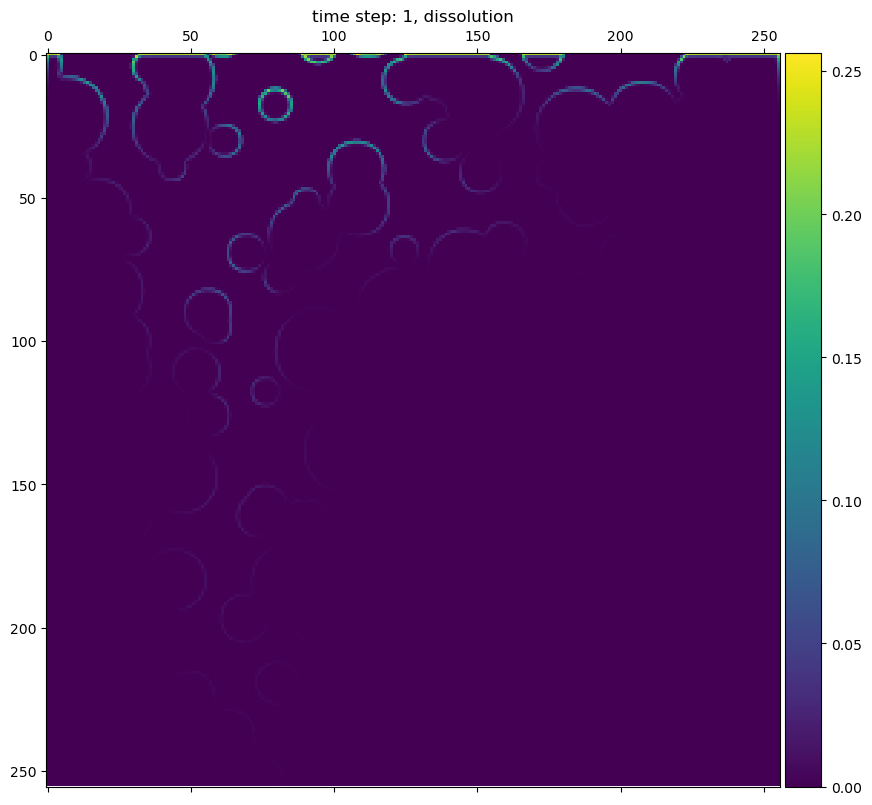

In [6]:

file_idx = 0
for idx_ in range(2): # range(C.shape[-1]):
    title = f'time step: {idx_}, eps'
    matshow(eps[file_idx, :, :, idx_], figsize=(10, 10), title=title)
    title = f'time step: {idx_}, C'
    matshow(C[file_idx, :, :, idx_], figsize=(10, 10), title=title)
    title = f'time step: {idx_}, U_x'
    matshow(Ux[file_idx, :, :, idx_], figsize=(10, 10), title=title)
    title = f'time step: {idx_}, U_y'
    matshow(Uy[file_idx, :, :, idx_], figsize=(10, 10), title=title)
    title = f'time step: {idx_}, dissolution'
    matshow((eps[file_idx, :, :, idx_+1] - eps[file_idx, :, :, idx_]), figsize=(10, 10), title=title)


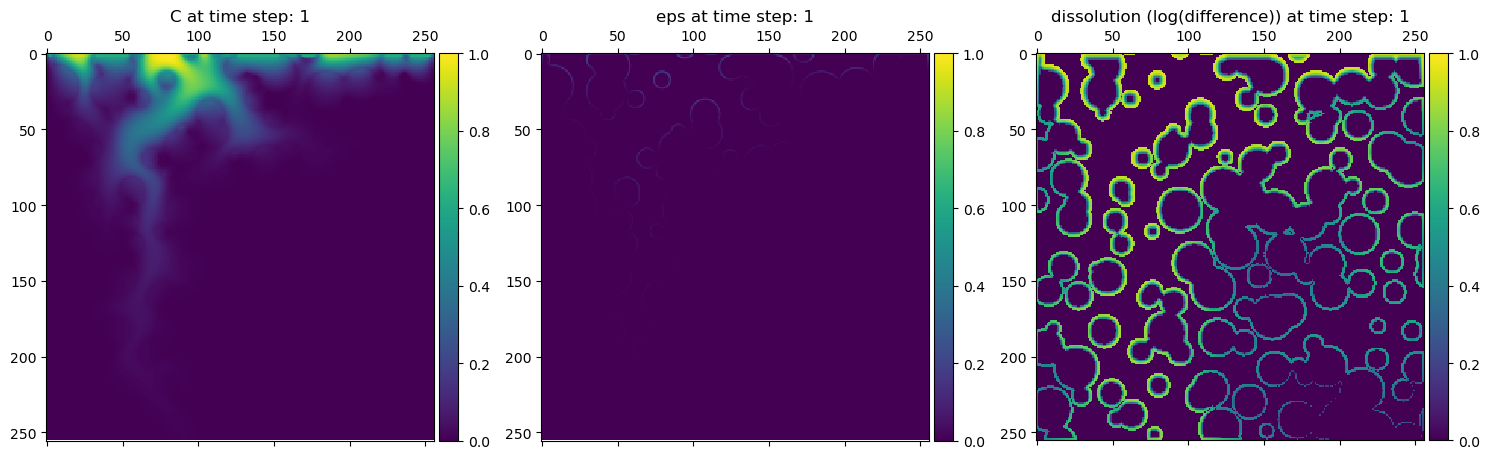

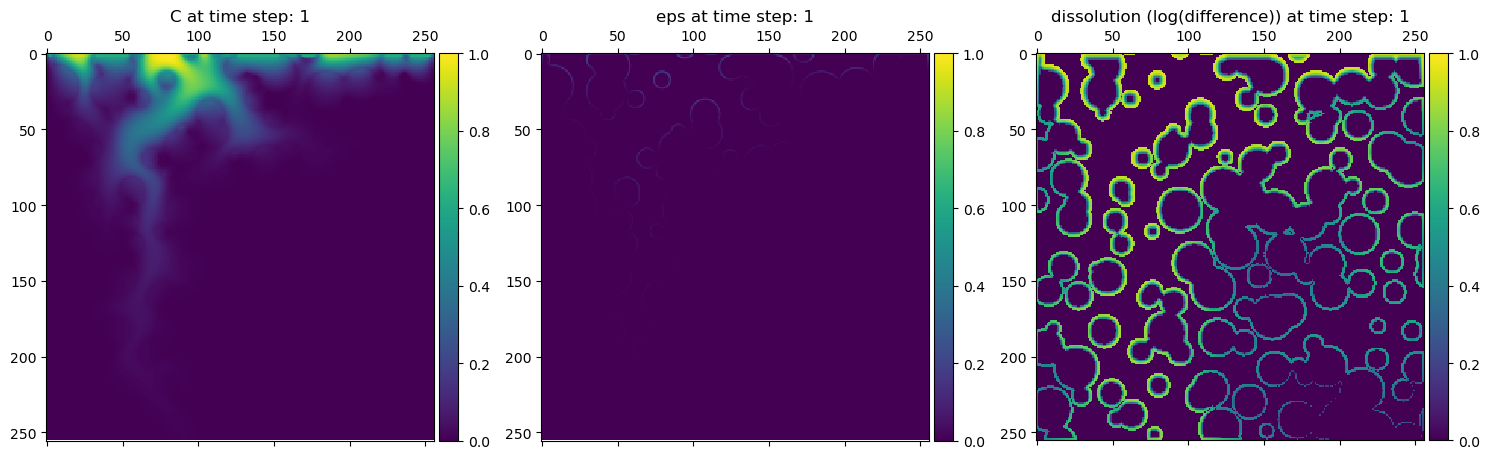

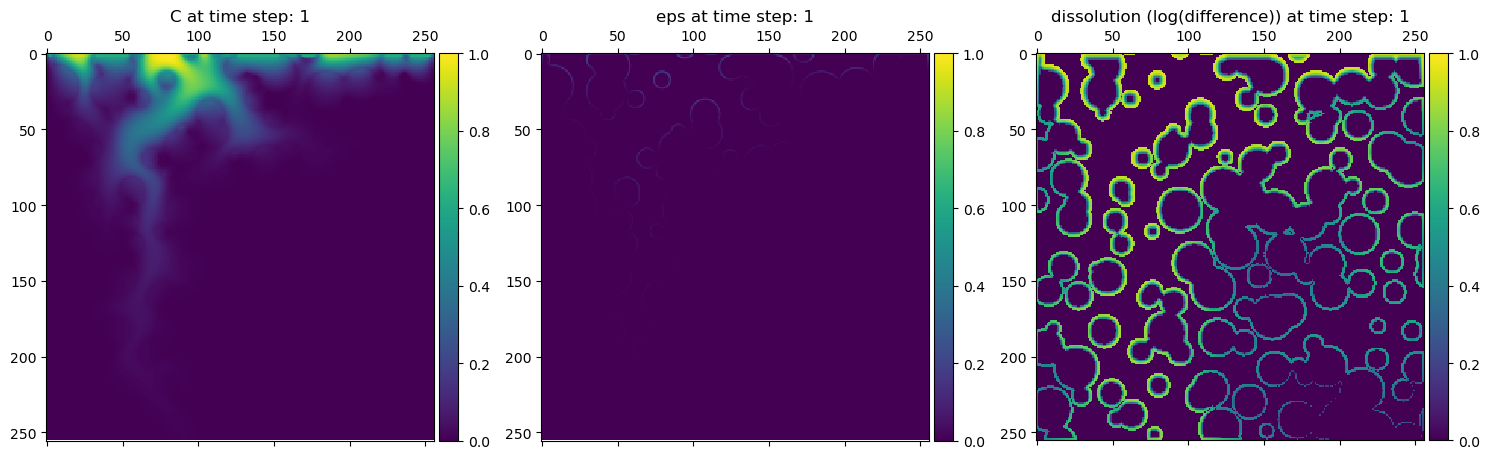

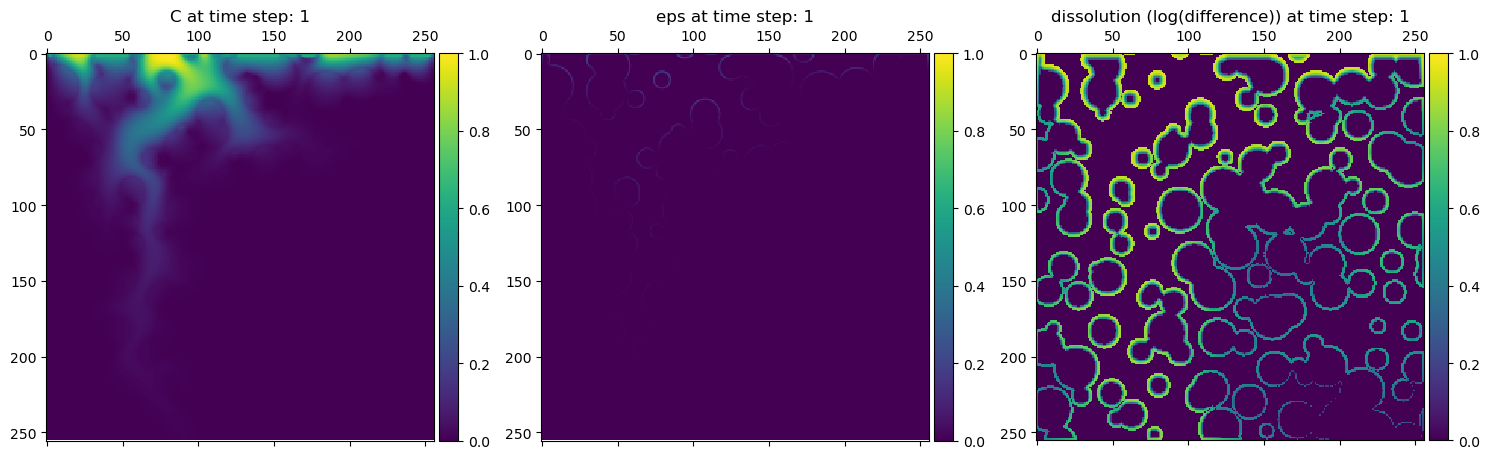

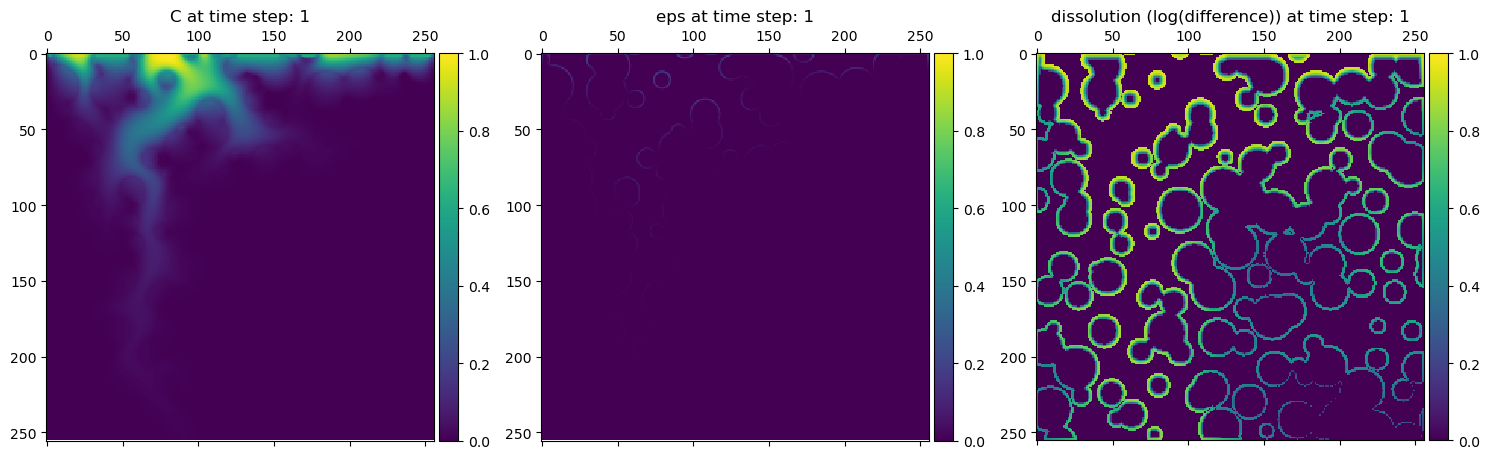

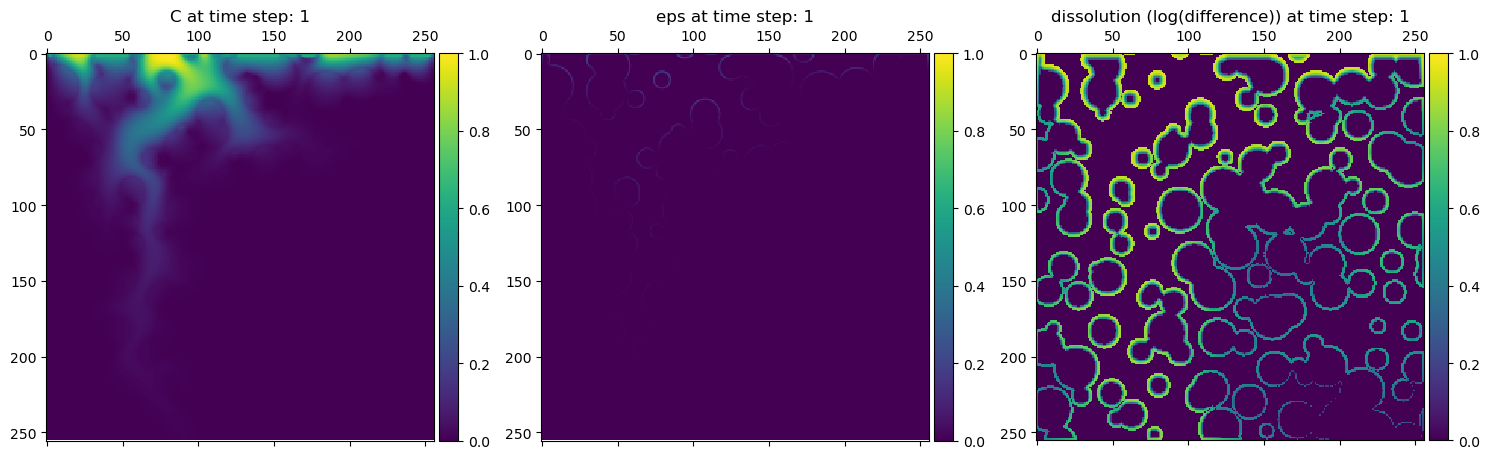

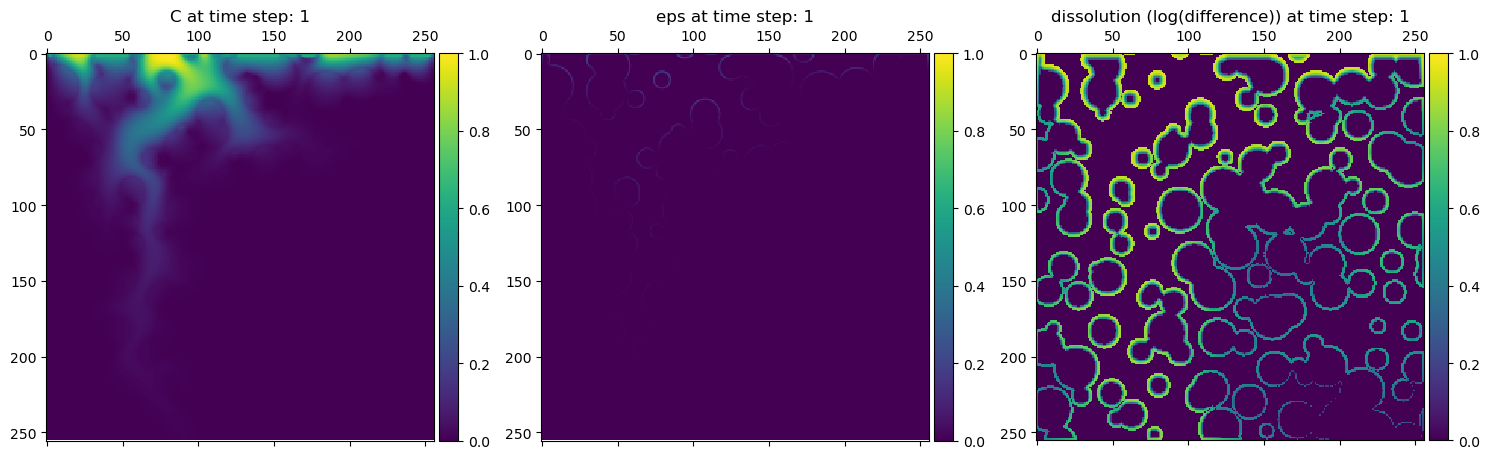

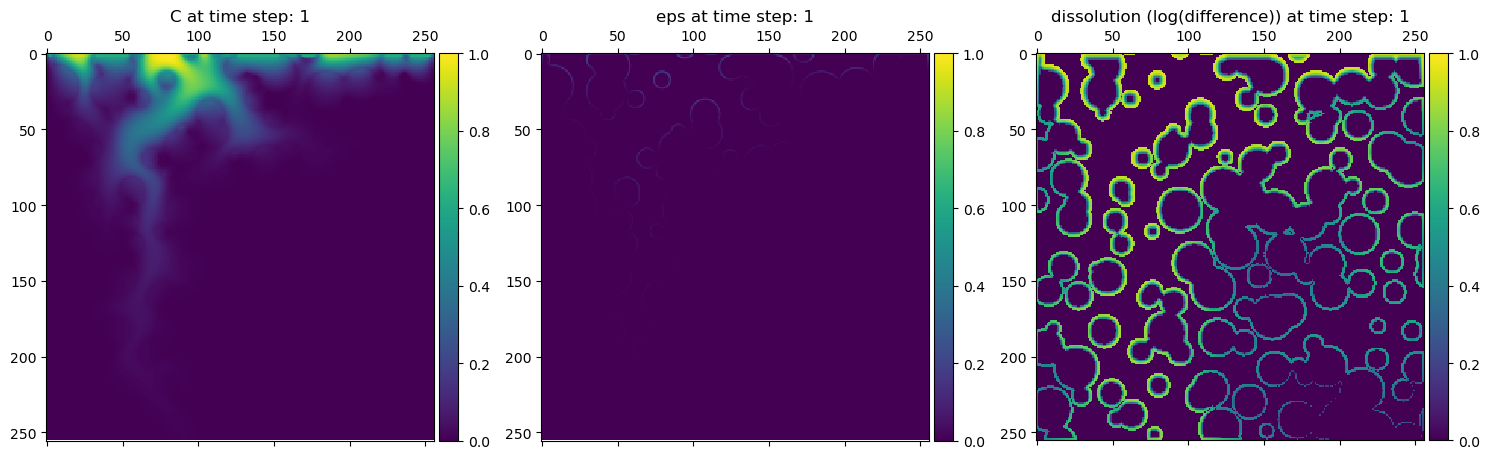

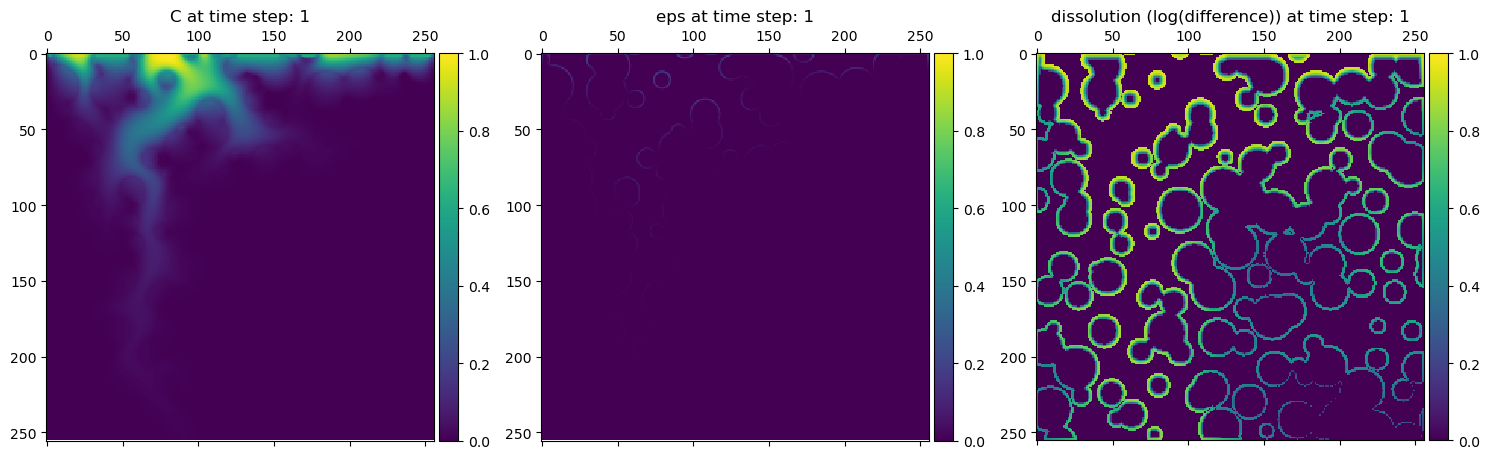

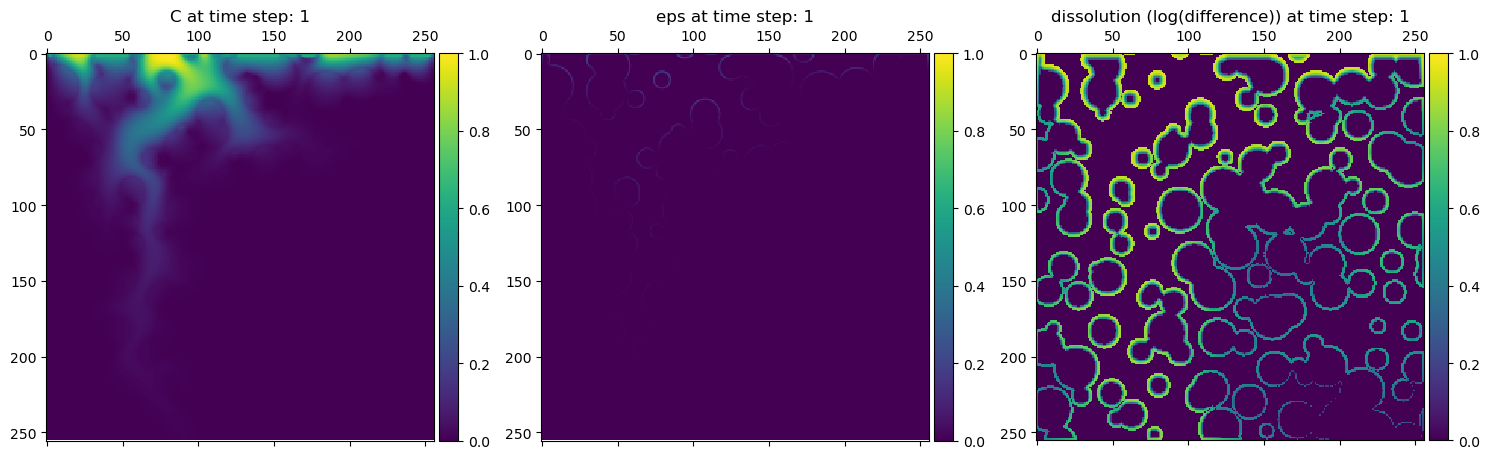

In [7]:
file_idx = 0
for idx in range(0, 100, 10):
    title = f'time step: {idx_}'
    save_filename = f'dissolution_{idx_}'

    matshow3(
        100*C[file_idx, :, :, idx_],
        eps[file_idx, :, :, idx_+1]-eps[file_idx, :, :, idx_],
        log_transform(eps[file_idx, :, :, idx_+1]-eps[file_idx, :, :, idx_]), 
        figsize=(15, 5),
        title=title,
        save_filename=save_filename)


In [8]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [9]:
from torch.utils.data import DataLoader, Dataset, RandomSampler

def preprocess_data_cube(data_dict, scaling_dict):
    print(f'preprocess_data_cube')

    masks = []
    images = []
    for file_idx in range(len(data_dict['C'])):
        C = data_dict['C'][file_idx][:, :, :-1]
        eps = data_dict['eps'][file_idx][:, :, :-1]
        Ux = data_dict['Ux'][file_idx][:, :, :-1]
        Uy = data_dict['Uy'][file_idx][:, :, :-1]
        eps_t = data_dict['eps'][file_idx][:, :, 1:]

        # mask = log_transform(eps_t - eps[:, :, :-1]) # this scaled from 0 to 1
        mask = eps_t - eps

        # these should be moved to preprocessing
        # C_scaled = log_transform(C*scaling_dict['C_scaling']) - 0.5 # scale to be from 0 to 1
        C = C*scaling_dict['C_scaling'] - 0.5
        Ux = (Ux - scaling_dict['Ux_mean']) / scaling_dict['Ux_std']
        Uy = (Uy - scaling_dict['Uy_mean']) / scaling_dict['Uy_std']
        eps = (eps - scaling_dict['eps_mean']) / scaling_dict['eps_std']


        image = np.stack([C, eps, Ux, Uy], axis=-1)
        image = np.swapaxes(image, 3, 2)

        masks.append(mask)
        images.append(image)
    
    masks = np.concatenate(masks, axis=-1)
    images = np.concatenate(images, axis=-1)
    print(f'preprocess_data_cube: {masks.shape}, {images.shape}')
    return images, masks

class DissolutionDataset(Dataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        data_dir (str): path to data folder
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
  
    def __init__(
            self,
            data_filenames,
            scaling_dict,
            augmentation=None, 
            preprocessing=None,
    ):

        # self.scaling_dict = scaling_dict
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        data_dict = load_datafiles(data_filenames)
        self.image, self.mask = preprocess_data_cube(data_dict, scaling_dict)
        print(self.image.shape, self.mask.shape)
        self.data_len = self.image.shape[-1]

    
    def __getitem__(self, idx):
        
        image = self.image[:, :, :, idx]
        mask = self.mask[:, :, idx]
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # assume one file for now
        return self.data_len # last element we cann't predict


In [10]:
C_scaling = 100
data_scalingdict = {
    'C_scaling': C_scaling,
    'Ux_mean': Ux_mean,
    'Ux_std': Ux_std,
    'Uy_mean': Uy_mean,
    'Uy_std': Uy_std,
    'eps_mean': eps_mean,
    'eps_std': eps_std,
}

In [11]:
data_filenames = get_filelist()
dataset = DissolutionDataset(data_filenames[:3], data_scalingdict)

loading the file: 256modelruns/Pe1_K1_0_0.hdf5
Keys: <KeysViewHDF5 ['C', 'Ux', 'Uy', 'eps', 'time']>
Done loading the variable C of shape: (260, 260, 101)
Done loading the variable Ux of shape: (260, 260, 101)
Done loading the variable Uy of shape: (260, 260, 101)
Done loading the variable eps of shape: (260, 260, 101)
Done loading the variable time of shape: (101,)
Done with 256modelruns/Pe1_K1_0_0.hdf5 == closing file now
loading the file: 256modelruns/Pe1_K1_0_1.hdf5
Keys: <KeysViewHDF5 ['C', 'Ux', 'Uy', 'eps', 'time']>
Done loading the variable C of shape: (260, 260, 101)
Done loading the variable Ux of shape: (260, 260, 101)
Done loading the variable Uy of shape: (260, 260, 101)
Done loading the variable eps of shape: (260, 260, 101)
Done loading the variable time of shape: (101,)
Done with 256modelruns/Pe1_K1_0_1.hdf5 == closing file now
loading the file: 256modelruns/Pe1_K1_0_2.hdf5
Keys: <KeysViewHDF5 ['C', 'Ux', 'Uy', 'eps', 'time']>
Done loading the variable C of shape: (260,

Dataset of size 300
plotting for time step: 0
(256, 256, 4) (256, 256)


/var/folders/gl/2ylcc5wx2jjgwr8qstjc3b480000gn/T/ipykernel_7135/2929336292.py:18: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/gl/2ylcc5wx2jjgwr8qstjc3b480000gn/T/ipykernel_7135/2929336292.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, n, i + 1)


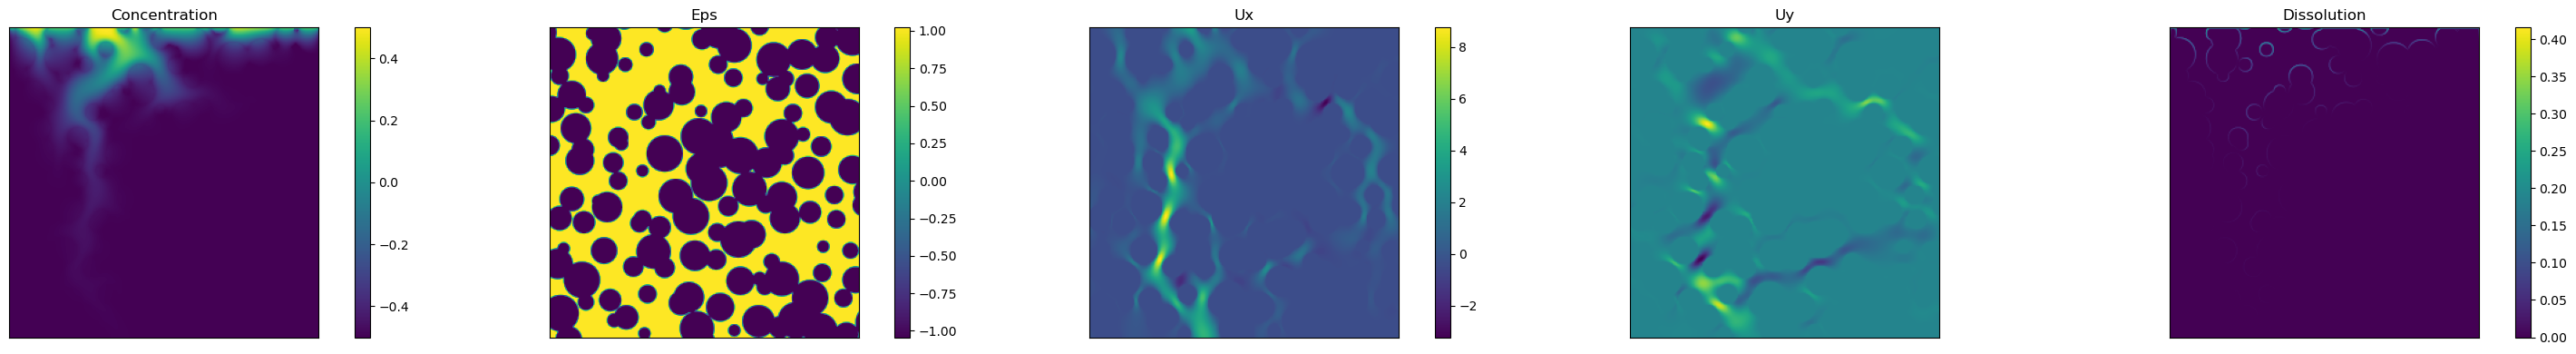

plotting for time step: 20
(256, 256, 4) (256, 256)


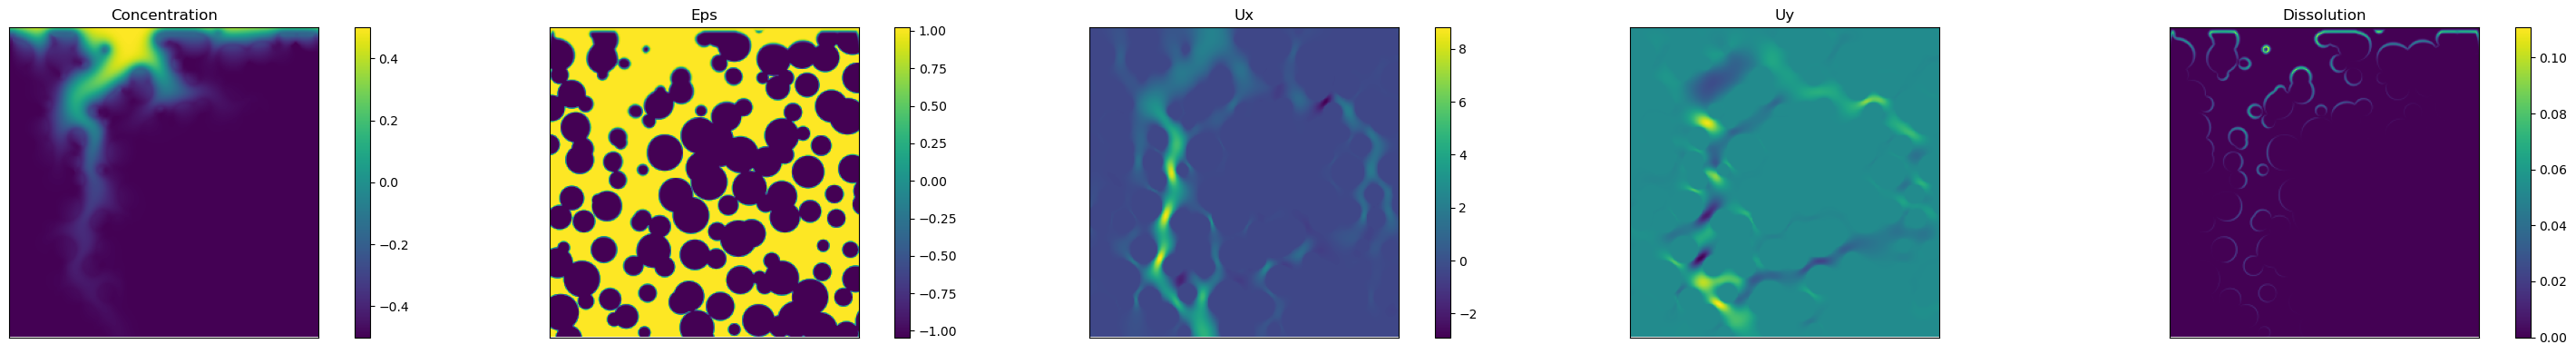

plotting for time step: 40
(256, 256, 4) (256, 256)


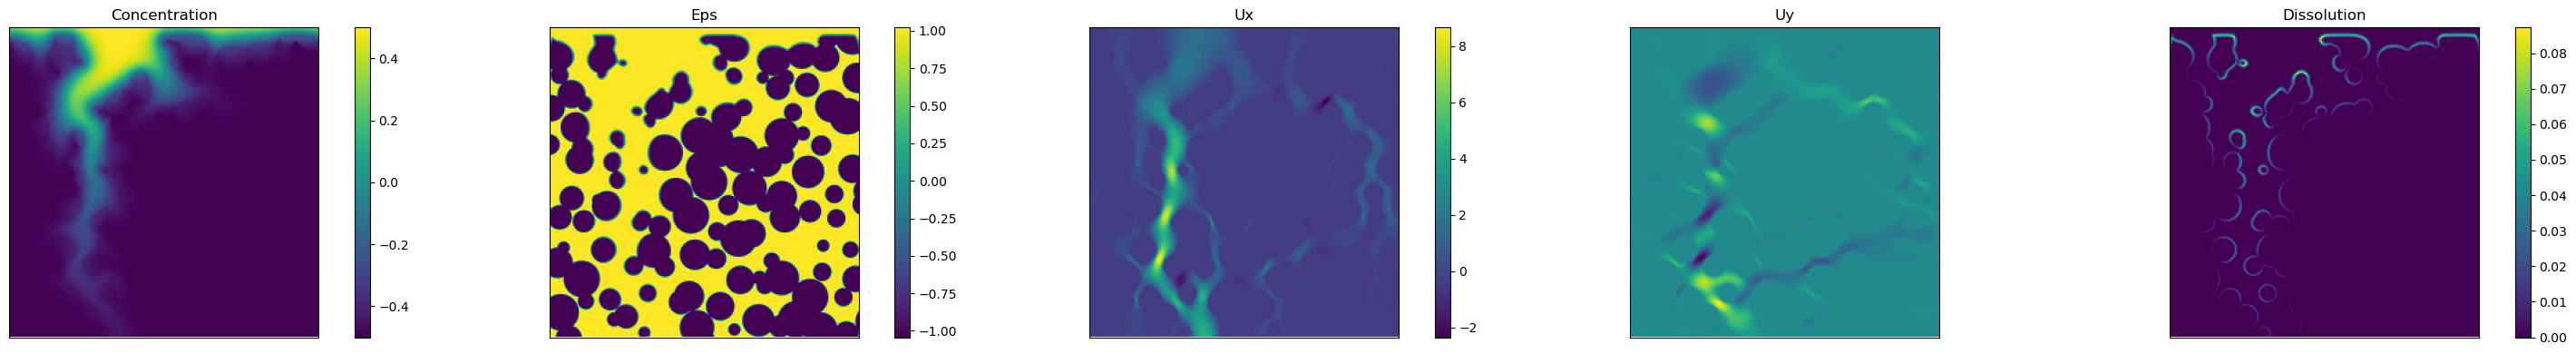

plotting for time step: 60
(256, 256, 4) (256, 256)


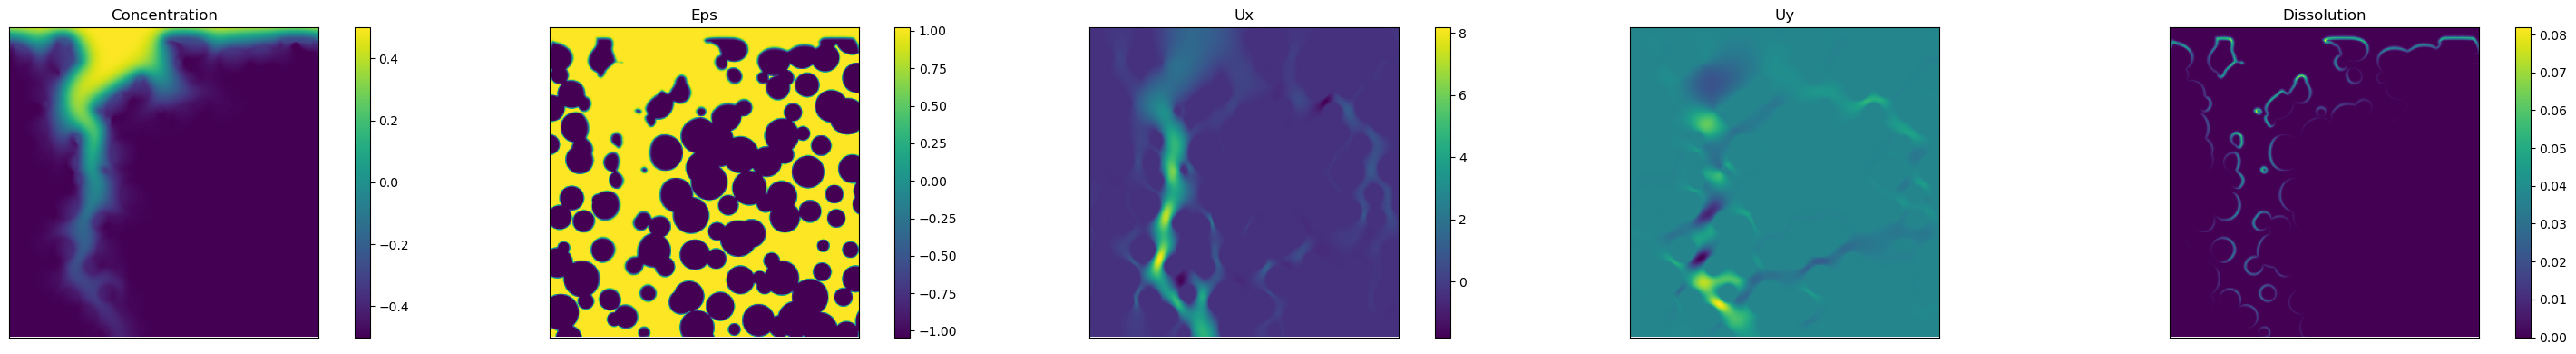

plotting for time step: 80
(256, 256, 4) (256, 256)


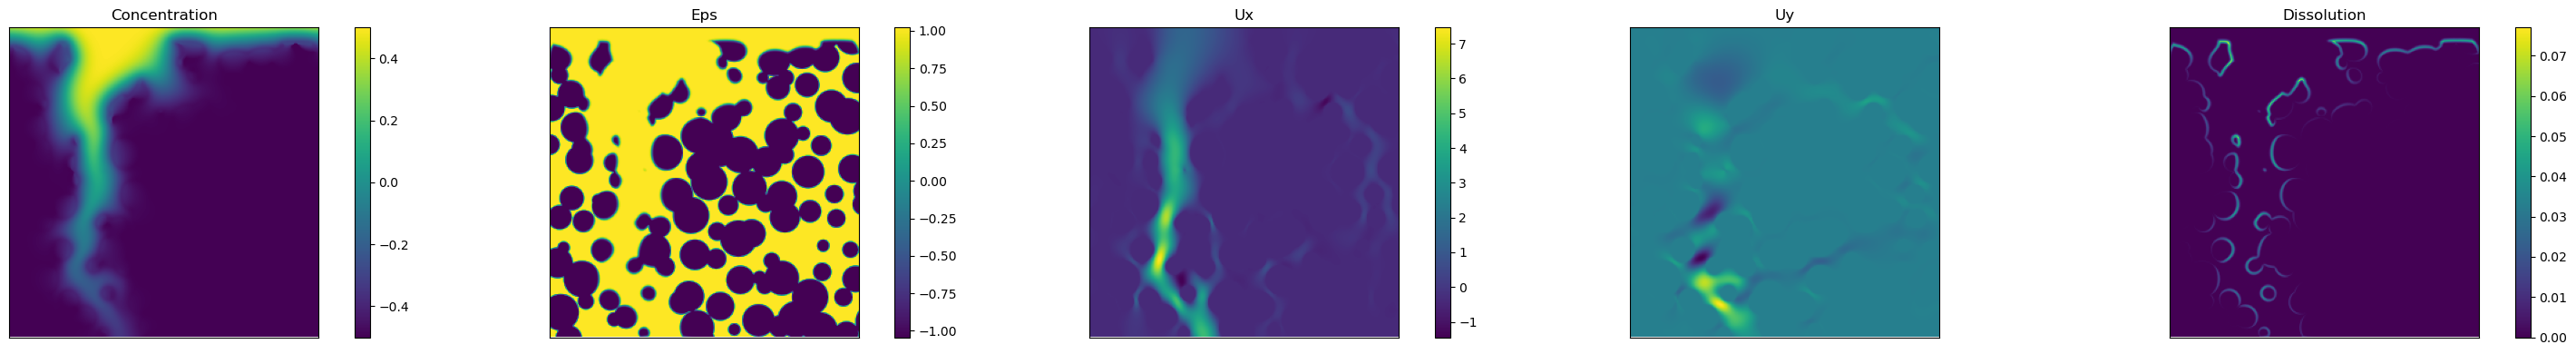

In [12]:
# helper function for data visualization

"""
WARNING: This function has been defined before
"""

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    fig = plt.figure(figsize=(32, 4))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        im = plt.imshow(image)
        plt.colorbar(im)
        fig.tight_layout()

    plt.show()


print(f'Dataset of size {len(dataset)}')

for idx_ in range(5):
    current_timestep = 20*idx_
    print(f'plotting for time step: {current_timestep}')
    image, mask = dataset[current_timestep] # get some sample
    print(image.shape, mask.shape)
    visualize(
        concentration=image[:,:, 0],
        eps=image[:,:, 1],
        Ux=image[:,:, 2],
        Uy=image[:,:, 3],
        dissolution=mask.squeeze(),
    )


In [13]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [
        albu.Resize(256, 256),  # not needed
        # albu.HorizontalFlip(p=0.5),
        # albu.VerticalFlip(p=0.5),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Resize to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(256, 256),  
    ]
    return albu.Compose(test_transform)


def to_tensor_img(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def to_tensor_mask(x, **kwargs):
    return x.astype('float32')

def get_preprocessing():
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=to_tensor_img, mask=to_tensor_mask),
    ]
    return albu.Compose(_transform)

In [14]:
data_filenames = get_filelist()

#### Visualize resulted augmented images and masks
dataset_train = DissolutionDataset(
    data_filenames[:n_training_samples],
    scaling_dict=data_scalingdict,
    augmentation=get_training_augmentation(), 
    preprocessing=None,
)

loading the file: 256modelruns/Pe1_K1_0_0.hdf5
Keys: <KeysViewHDF5 ['C', 'Ux', 'Uy', 'eps', 'time']>
Done loading the variable C of shape: (260, 260, 101)
Done loading the variable Ux of shape: (260, 260, 101)
Done loading the variable Uy of shape: (260, 260, 101)
Done loading the variable eps of shape: (260, 260, 101)
Done loading the variable time of shape: (101,)
Done with 256modelruns/Pe1_K1_0_0.hdf5 == closing file now
loading the file: 256modelruns/Pe1_K1_0_1.hdf5
Keys: <KeysViewHDF5 ['C', 'Ux', 'Uy', 'eps', 'time']>
Done loading the variable C of shape: (260, 260, 101)
Done loading the variable Ux of shape: (260, 260, 101)
Done loading the variable Uy of shape: (260, 260, 101)
Done loading the variable eps of shape: (260, 260, 101)
Done loading the variable time of shape: (101,)
Done with 256modelruns/Pe1_K1_0_1.hdf5 == closing file now
loading the file: 256modelruns/Pe1_K1_0_2.hdf5
Keys: <KeysViewHDF5 ['C', 'Ux', 'Uy', 'eps', 'time']>
Done loading the variable C of shape: (260,

plotting for time step: 0


/var/folders/gl/2ylcc5wx2jjgwr8qstjc3b480000gn/T/ipykernel_7135/2929336292.py:18: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/gl/2ylcc5wx2jjgwr8qstjc3b480000gn/T/ipykernel_7135/2929336292.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, n, i + 1)


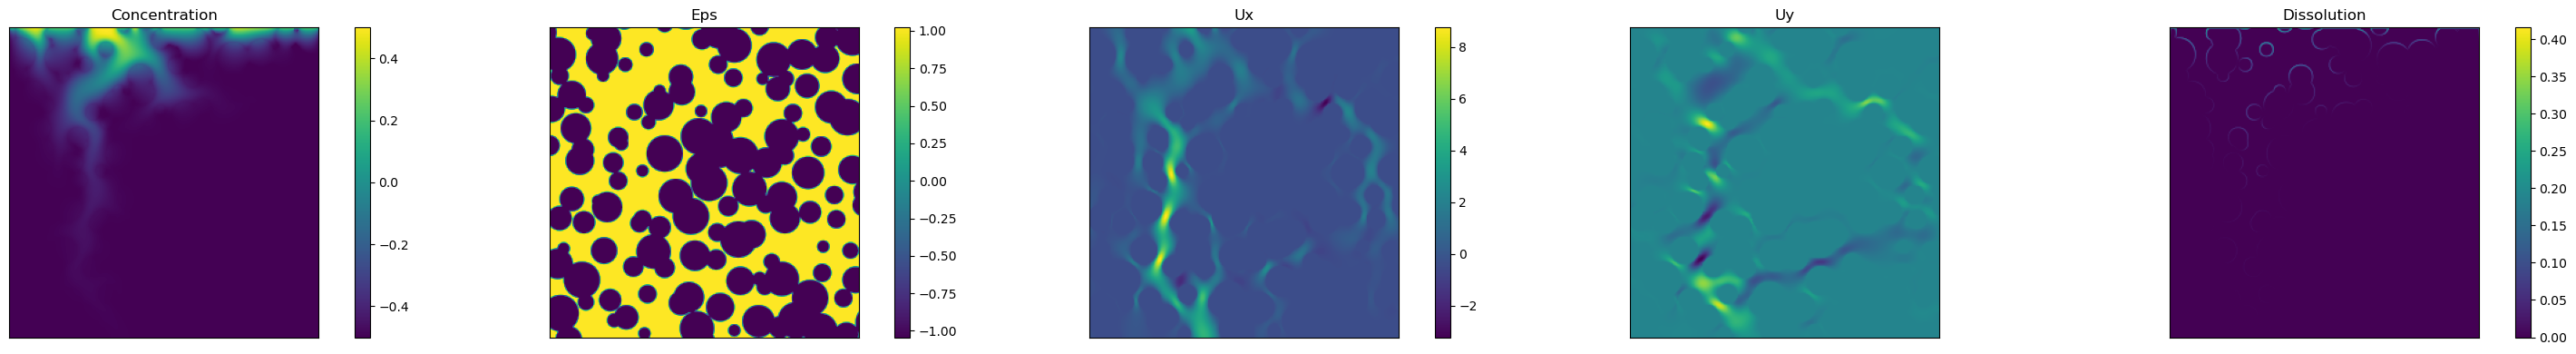

plotting for time step: 10


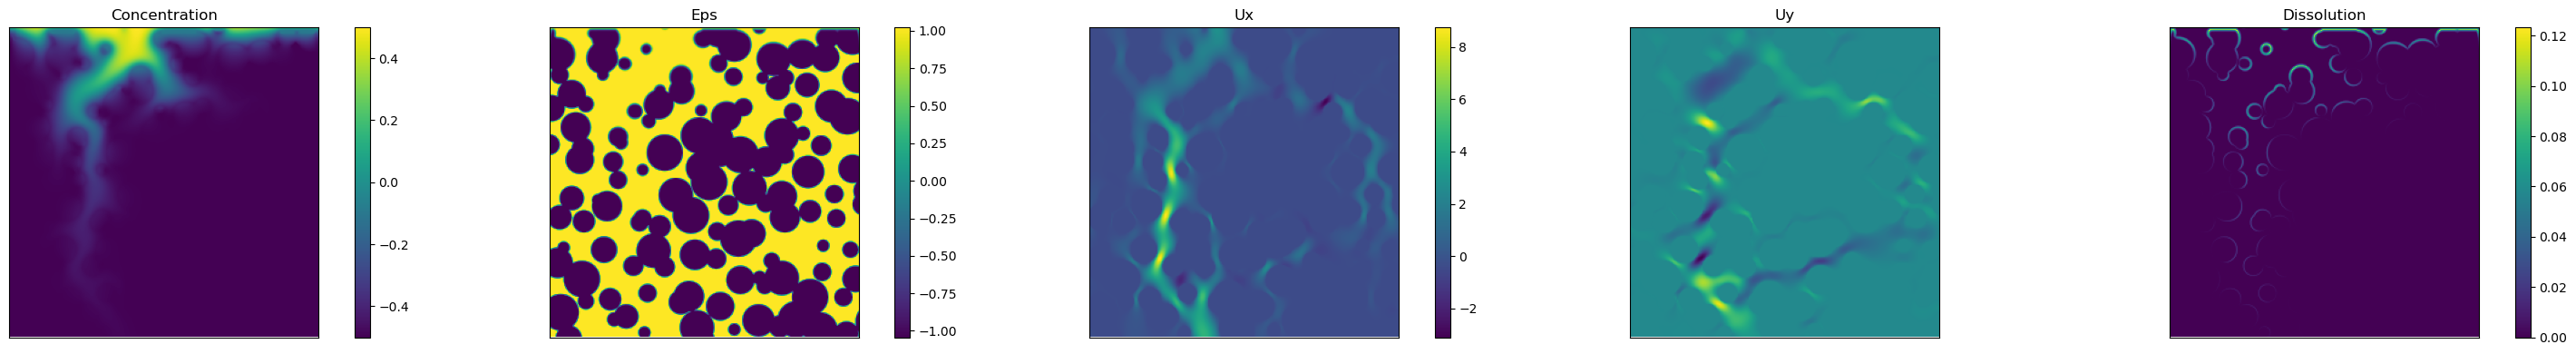

plotting for time step: 20


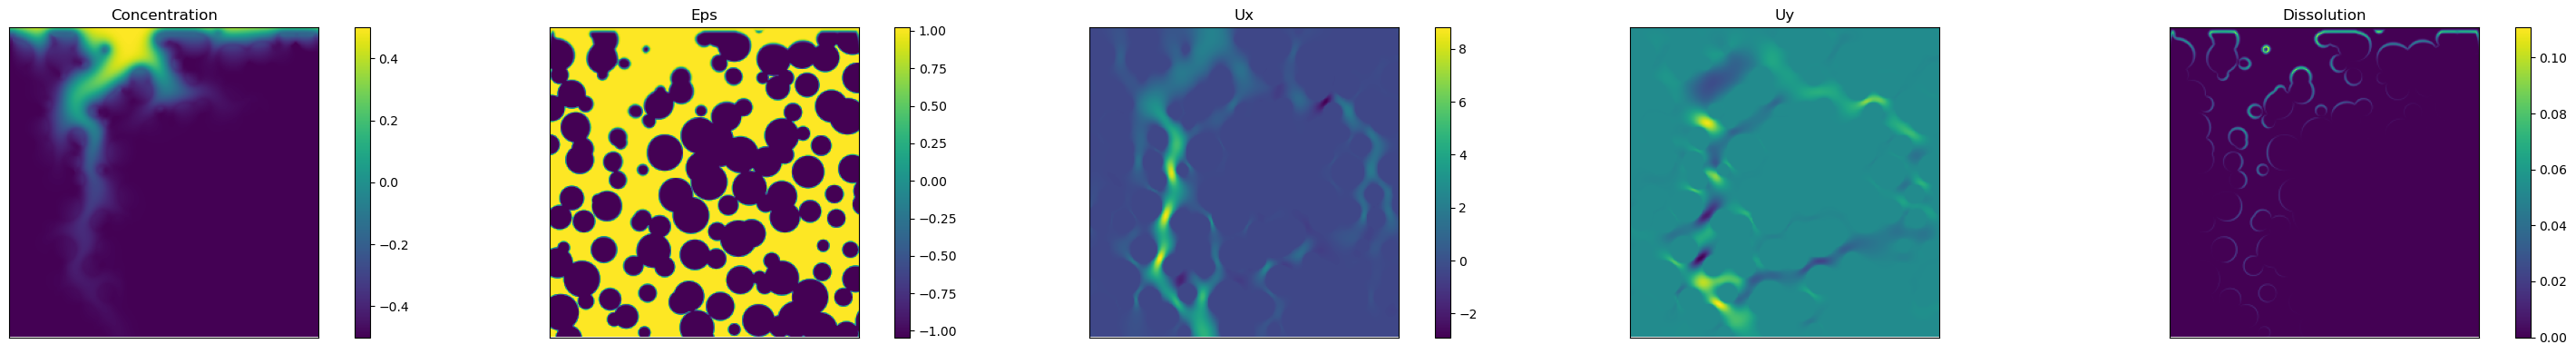

plotting for time step: 30


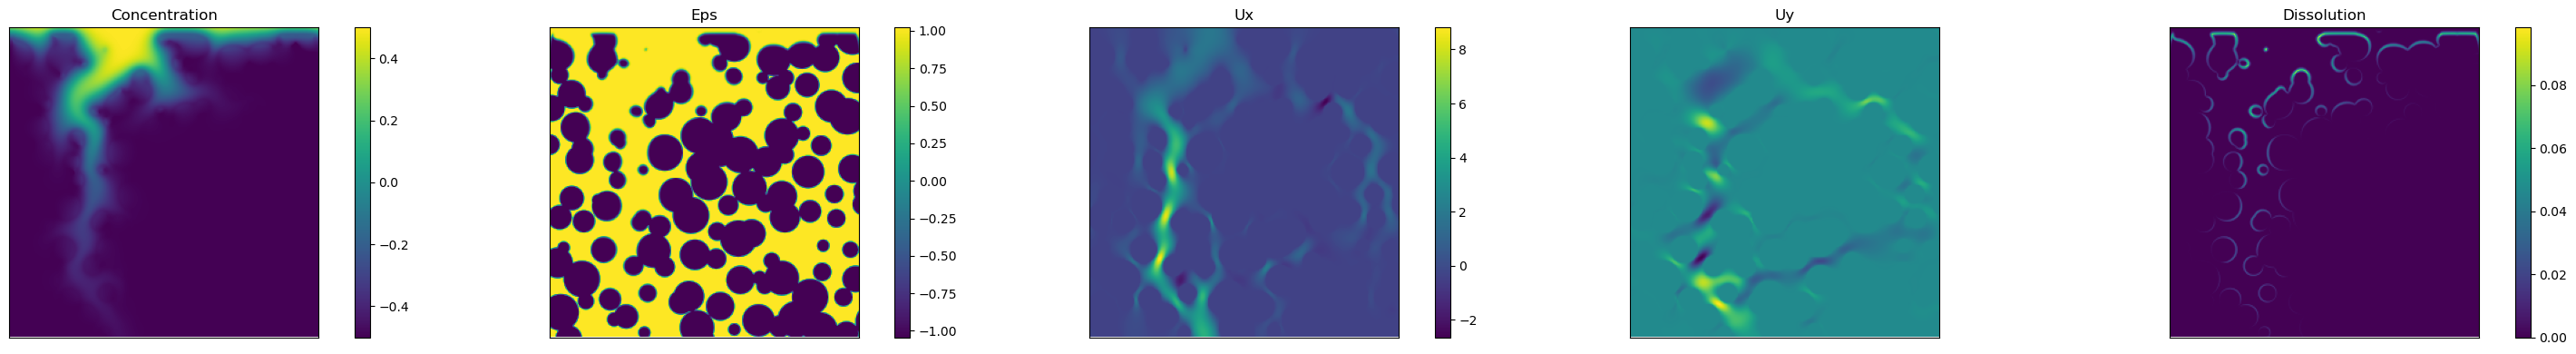

plotting for time step: 40


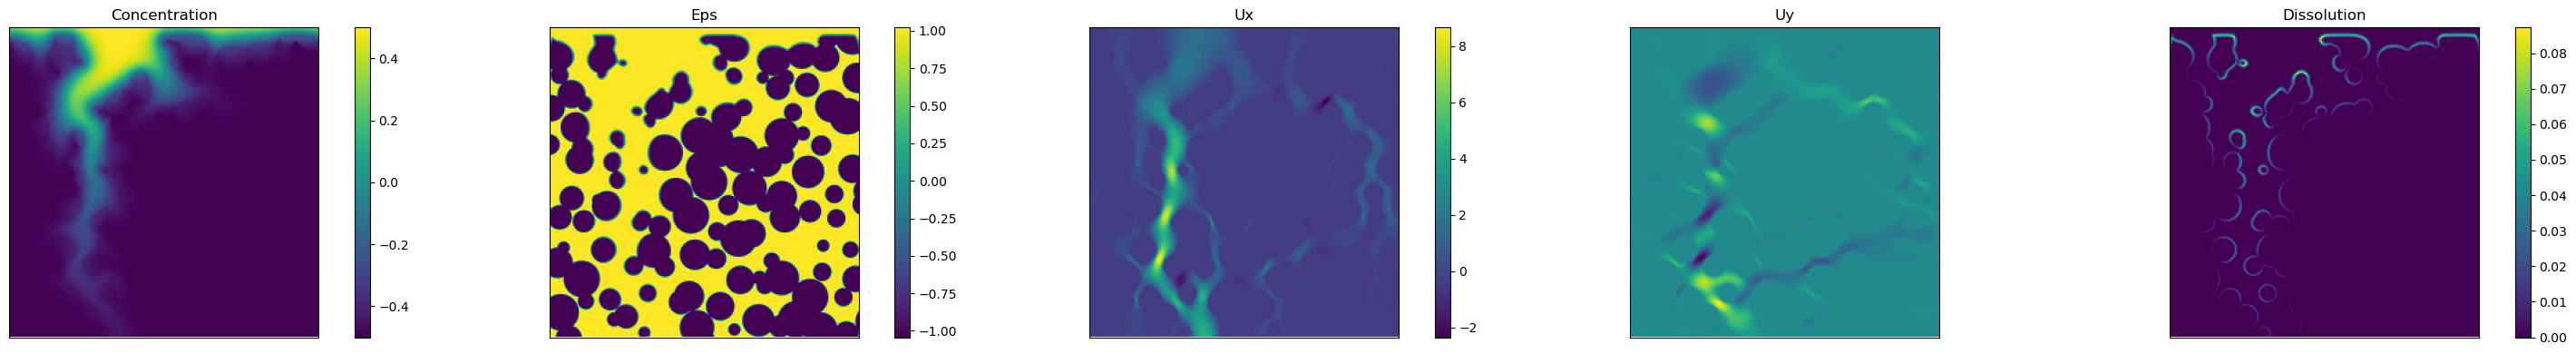

In [15]:
# same image with different random transforms
for idx_ in range(5):
    current_timestep = 10*idx_
    print(f'plotting for time step: {current_timestep}')
    image, mask = dataset_train[current_timestep] # get some sample
    visualize(
        concentration=image[:,:, 0],
        eps=image[:,:, 1],
        Ux=image[:,:, 2],
        Uy=image[:,:, 3],
        dissolution=mask.squeeze(),
    )

In [16]:
dataset_valid = DissolutionDataset(
    data_filenames[n_training_samples:],
    scaling_dict=data_scalingdict,
    augmentation=get_validation_augmentation(), 
    preprocessing=None,
)

loading the file: 256modelruns/Pe1_K1_3_0.hdf5
Keys: <KeysViewHDF5 ['C', 'Ux', 'Uy', 'eps', 'time']>
Done loading the variable C of shape: (260, 260, 101)
Done loading the variable Ux of shape: (260, 260, 101)
Done loading the variable Uy of shape: (260, 260, 101)
Done loading the variable eps of shape: (260, 260, 101)
Done loading the variable time of shape: (101,)
Done with 256modelruns/Pe1_K1_3_0.hdf5 == closing file now
loading the file: 256modelruns/Pe1_K1_3_1.hdf5
Keys: <KeysViewHDF5 ['C', 'Ux', 'Uy', 'eps', 'time']>
Done loading the variable C of shape: (260, 260, 101)
Done loading the variable Ux of shape: (260, 260, 101)
Done loading the variable Uy of shape: (260, 260, 101)
Done loading the variable eps of shape: (260, 260, 101)
Done loading the variable time of shape: (101,)
Done with 256modelruns/Pe1_K1_3_1.hdf5 == closing file now
loading the file: 256modelruns/Pe1_K1_3_2.hdf5
Keys: <KeysViewHDF5 ['C', 'Ux', 'Uy', 'eps', 'time']>
Done loading the variable C of shape: (260,

plotting for time step: 0


/var/folders/gl/2ylcc5wx2jjgwr8qstjc3b480000gn/T/ipykernel_7135/2929336292.py:18: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/gl/2ylcc5wx2jjgwr8qstjc3b480000gn/T/ipykernel_7135/2929336292.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, n, i + 1)


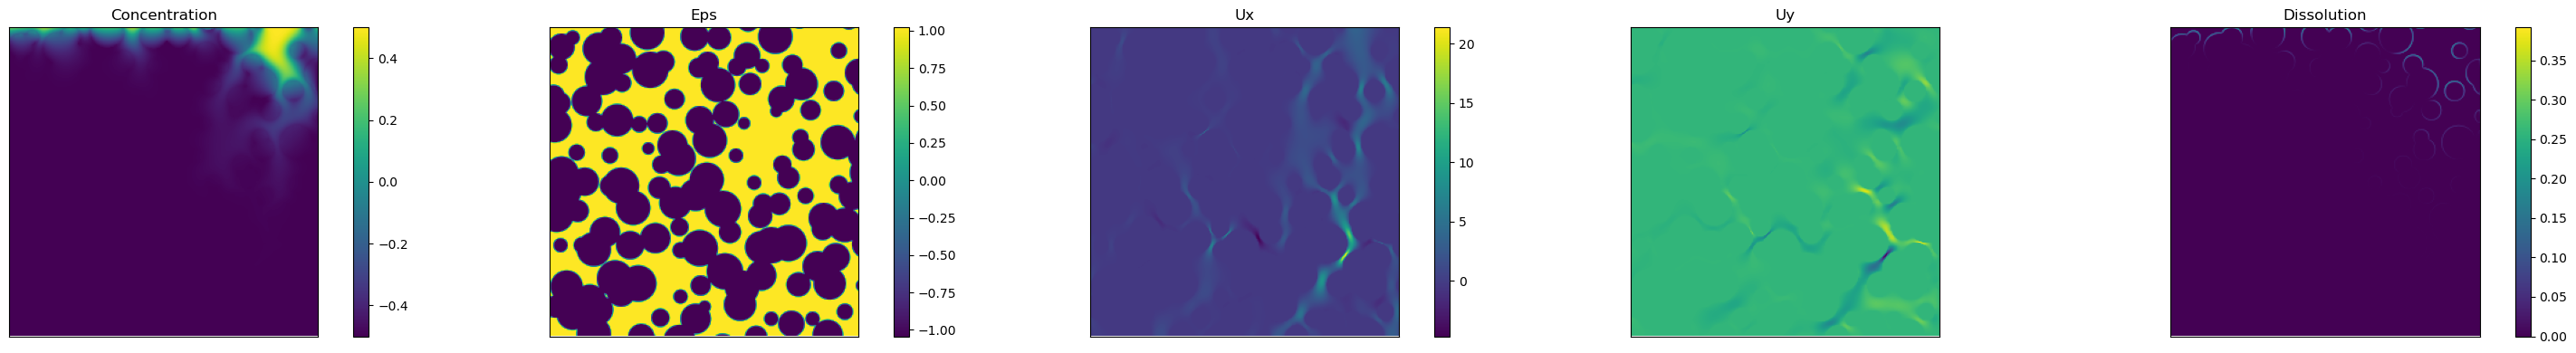

plotting for time step: 10


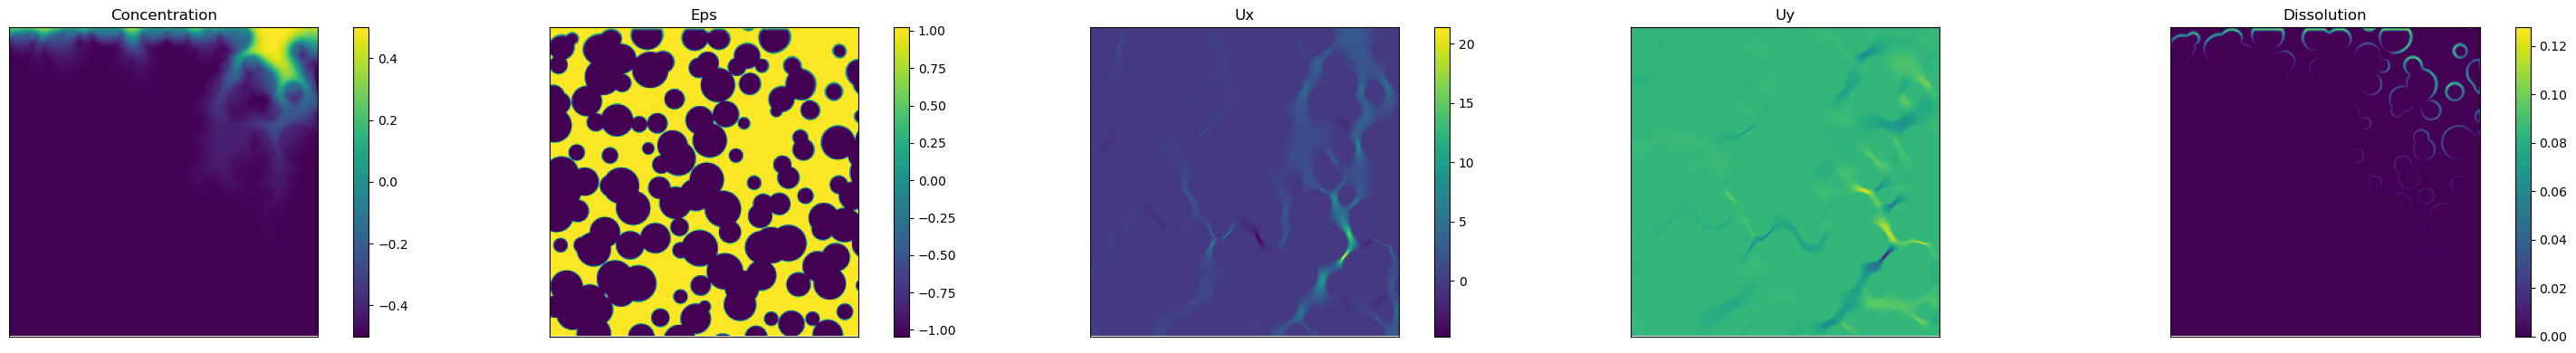

plotting for time step: 20


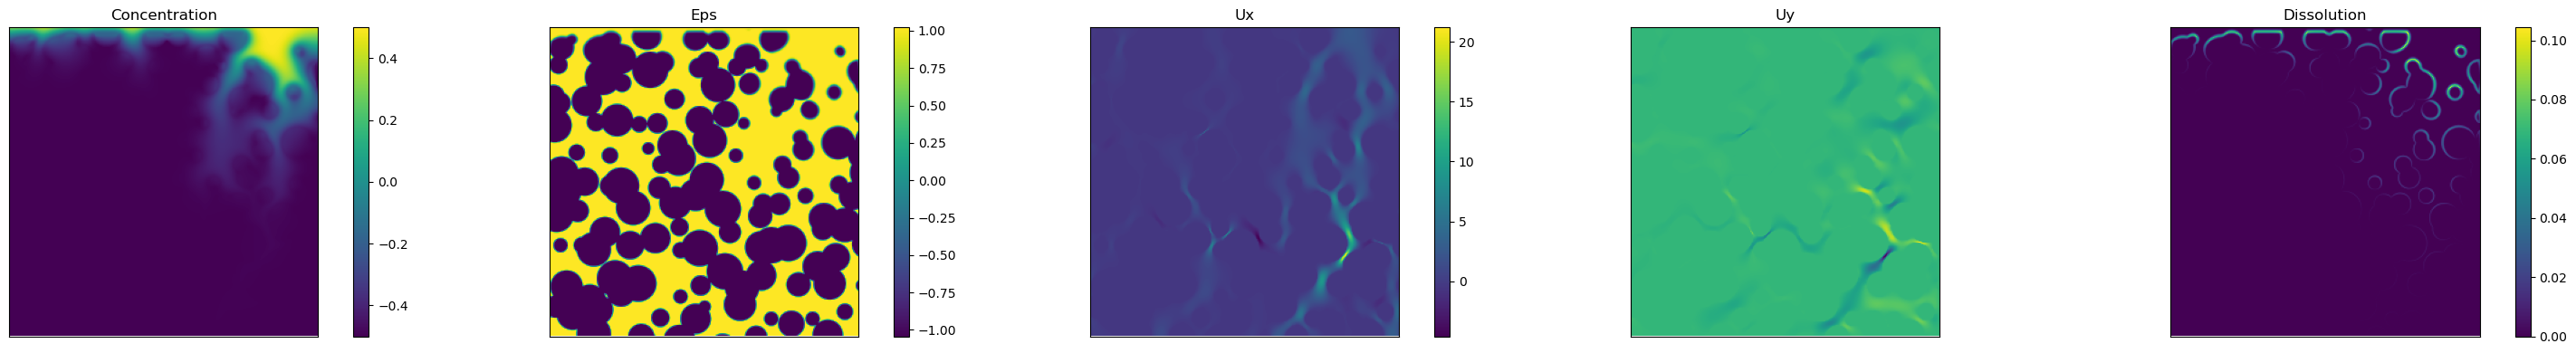

plotting for time step: 30


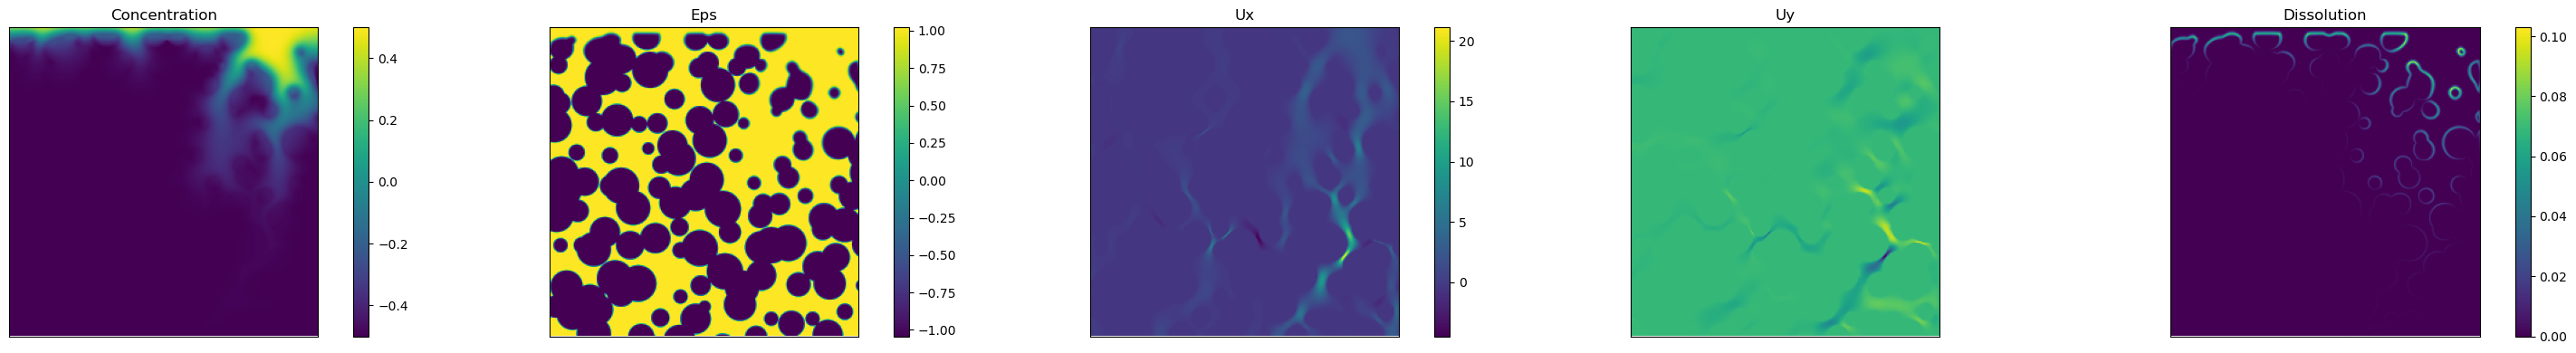

In [17]:
for idx_ in range(4):
    current_timestep = 10*idx_
    print(f'plotting for time step: {current_timestep}')
    image, mask = dataset_valid[current_timestep] # get some sample
    visualize(
        concentration=image[:,:, 0],
        eps=image[:,:, 1],
        Ux=image[:,:, 2],
        Uy=image[:,:, 3],
        dissolution=mask.squeeze(),
    )

In [18]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm
from torch.utils.data import RandomSampler

In [19]:
from datetime import datetime

dataset_train = DissolutionDataset(
    data_filenames[:n_training_samples],
    scaling_dict=data_scalingdict,
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(),
)

dataset_valid = DissolutionDataset(
    data_filenames[n_training_samples:],
    scaling_dict=data_scalingdict,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(),
)

loading the file: 256modelruns/Pe1_K1_0_0.hdf5
Keys: <KeysViewHDF5 ['C', 'Ux', 'Uy', 'eps', 'time']>
Done loading the variable C of shape: (260, 260, 101)
Done loading the variable Ux of shape: (260, 260, 101)
Done loading the variable Uy of shape: (260, 260, 101)
Done loading the variable eps of shape: (260, 260, 101)
Done loading the variable time of shape: (101,)
Done with 256modelruns/Pe1_K1_0_0.hdf5 == closing file now
loading the file: 256modelruns/Pe1_K1_0_1.hdf5
Keys: <KeysViewHDF5 ['C', 'Ux', 'Uy', 'eps', 'time']>
Done loading the variable C of shape: (260, 260, 101)
Done loading the variable Ux of shape: (260, 260, 101)
Done loading the variable Uy of shape: (260, 260, 101)
Done loading the variable eps of shape: (260, 260, 101)
Done loading the variable time of shape: (101,)
Done with 256modelruns/Pe1_K1_0_1.hdf5 == closing file now
loading the file: 256modelruns/Pe1_K1_0_2.hdf5
Keys: <KeysViewHDF5 ['C', 'Ux', 'Uy', 'eps', 'time']>
Done loading the variable C of shape: (260,

In [20]:
# train_sampler = RandomSampler(dataset_train, replacement=False, num_samples=None)
train_sampler = RandomSampler(dataset_train, replacement=True, num_samples=10000)
train_loader = DataLoader(dataset_train, batch_size=64, num_workers=16, sampler=train_sampler, drop_last=True)                        
valid_loader = DataLoader(dataset_valid, batch_size=4, num_workers=4, shuffle=False, drop_last=True)

/Users/captainjack/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [42]:
import torch
import segmentation_models_pytorch as smp
from tqdm import tqdm
import pandas as pd

# encoder_name = 'resnet34'
# model = smp.Unet(
#     encoder_name,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights=None,           # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=4,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=1,                      # model output channels (number of classes in your dataset)
#     activation='sigmoid', #'sigmoid',  # 'clamp', # between 0 and 1
# )

from convlstm import ConvLSTM


x = torch.rand( (32, 1,1,128, 128) )

model = ConvLSTM(input_dim=5,
                 hidden_dim=[128, 128],
                 kernel_size=(3, 3),
                 num_layers=2,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False)

model(x)


# l2_loss = torch.nn.MSELoss() # smp.losses.DiceLoss()
# l1_loss = torch.nn.L1Loss() # solution is sparse

# metrics = [
#     torch.nn.L1Loss
# ]

# optimizer = torch.optim.Adam([ 
#     dict(params=model.parameters(), lr=5e-4),
# ])

# def save_checkpoint(state_dict, model_filename):
#     torch.save(state_dict, model_filename)
#     print(f'saved model to {model_filename}')


RuntimeError: Given groups=1, weight of size [512, 133, 3, 3], expected input[32, 129, 128, 128] to have 133 channels, but got 129 channels instead

In [ ]:
cpu_device = torch.device('cpu')
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
max_epochs = 20
for epoch_counter in range(max_epochs):
    # print(f'length of train/val dataloaders are: {len(train_loader)}, {len(valid_loader)}')

    time_str = datetime.now().strftime("%H:%M:%S")
    print(f'{time_str}: epoch_counter: {epoch_counter}, start of training')

    # training steps
    train_loss = 0
    for imgs, masks in tqdm(train_loader):
        imgs, masks = imgs.to(device, non_blocking=True), masks.to(device, non_blocking=True)
        # c_field = imgs[:, 0, :, :].squeeze() + 0.5
        optimizer.zero_grad()

        preds = model(imgs).squeeze()

        # l2_loss_values = l2_loss(masks, preds)
        # l1_loss_values = l1_loss(masks, preds)
        # loss_values = l2_loss_values + l1_loss_values
        loss_values = l2_loss(masks, preds) # weighted_mse_loss(masks, preds, (c_field+1)**2)
        loss_values.backward()
        optimizer.step()
        train_loss += loss_values
        time_str = datetime.now().strftime("%H:%M:%S")
    print(f'{time_str}: epoch_counter {epoch_counter}, current loss {loss_values.item()}')
    
    # check point every 10 epochs
    if epoch_counter % 10 == 0: 
        model = model.to(cpu_device)
        state_dict = {
            'epoch': epoch_counter,
            'model_state_dict': model.state_dict(),
        }
        model_filename = f"model256_weights/resnet34_{epoch_counter}_l2loss.pth"
        save_checkpoint(state_dict, model_filename)
        print('Saved a checkpoint {}'.format(model_filename))
        model = model.to(device)

In [ ]:
with torch.no_grad():
    # loop 1 on training data
    train_loss = []
    # train_loss_scaled = []
    preds_list_train = []
    masks_list_train = []

    for imgs, masks in tqdm(train_loader):
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True) # .squeeze()
        preds = model(imgs).squeeze()

        l2_loss_values = l2_loss(masks, preds)
        train_loss.append(l2_loss_values.item())

        # store the true values
        # Changed to store in CPU
        masks_list_train.append(masks.to(cpu_device).numpy())
        preds_list_train.append(preds.to(cpu_device).numpy())

    train_loss = np.array(train_loss)
    print(f'train_loss: {train_loss.mean()}')
    
    val_loss = []
    preds_list_val = []
    masks_list_val = []

    # loop 2 on validation data
    for imgs, masks in tqdm(valid_loader):
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)# .squeeze()
        preds = model(imgs).squeeze()

        l2_loss_values = l2_loss(masks, preds)
        val_loss.append(l2_loss_values.item())

        # store the true values
        # Changed to store in CPU
        masks_list_val.append(masks.to(cpu_device).numpy())
        preds_list_val.append(preds.to(cpu_device).numpy())

    val_loss = np.array(val_loss)
    print(f'validation_loss: {val_loss.mean()}') #, val_loss_scaled: {val_loss_scaled.mean()}')

In [ ]:
preds_list_train = np.concatenate(preds_list_train)
masks_list_train = np.concatenate(masks_list_train)

preds_list_val = np.concatenate(preds_list_val)
masks_list_val = np.concatenate(masks_list_val)

In [ ]:
def matshow_error(pred, truth, figsize=(40, 18), scale=False, title=None, filename=None):
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    
    v_max = max(truth.max(), pred.max())
    v_min = max(truth.min(), pred.min())

    if scale:
        im = ax[0].matshow(pred, vmin=0, vmax=1, cmap=plt.get_cmap('Reds'))# 'inferno_r'))
    else:
        im = ax[0].matshow(pred, vmin=v_min, vmax=v_max, cmap=plt.get_cmap('Reds'))# 'inferno_r'))
    # im.set_clim(0.0, 0.3)
    ax[0].set_title(f'{title} prediction')
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)

    if scale:
        im = ax[1].matshow(truth, vmin=0, vmax=1, cmap=plt.get_cmap('Reds'))# 'inferno_r'))
    else:
        im = ax[1].matshow(truth, vmin=v_min, vmax=v_max, cmap=plt.get_cmap('Reds'))# 'inferno_r'))
    # im.set_clim(0.0, 0.3)
    ax[1].set_title(f'{title} reference')
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    # error = np.abs(pred-truth)
    error = pred-truth

    im = ax[2].matshow(error, cmap=plt.get_cmap('seismic')) #.get_cmap('RdGy'))
    max_abs_error = np.max(np.abs(error))
    # Set the color limits dynamically centered around zero
    clim = (-max_abs_error, max_abs_error)
    im.set_clim(clim)

    ax[2].set_title(f'{title} error')
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

for sample_idx in range(1): #12):
    for time_step in [0, 1, 3, 7, 10, 20, 40, 60, 90, 99]:
        preds = preds_list_train[sample_idx*100+time_step, :, :]
        masks = masks_list_train[sample_idx*100+time_step, :, :]
        # matshow2(scaling_func(preds), scaling_func(masks), title=f'train sample: {sample_idx}, scaled prediction eps', filename='original_eps.pdf')
        matshow_error(
            preds,
            masks, 
            title=f'train sample: {sample_idx}, timestep: {time_step}, eps: ', 
            filename=f'vis_results/training_eps_{sample_idx}_{time_step}.pdf',
            figsize=(15, 7))
        
for sample_idx in range(1): #4):
    for time_step in [0, 1, 3, 7, 10, 20, 40, 60, 90, 99]:
        preds = preds_list_val[sample_idx*100+time_step, :, :]
        masks = masks_list_val[sample_idx*100+time_step, :, :]
        # matshow2(scaling_func(preds), scaling_func(masks), title=f'validation sample: {sample_idx}, scaled prediction eps', filename='original_eps.pdf')
        matshow_error(
            preds,
            masks,
            title=f'validation sample: {sample_idx}, timestep: {time_step}, eps: ', 
            filename=f'vis_results/validation_eps_{sample_idx}_{time_step}.pdf',
            figsize=(15, 7))